## Bayesian Methods in Cognitive Modeling
PyMC code for Lee, M. D. (2018). Bayesian methods in cognitive modeling. The Stevens’ handbook of experimental psychology and cognitive neuroscience, 5(), 37–84.


In [2]:
import scipy.io as sio
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pprint # for prety dictionaries
import ipywidgets as widgets
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import xarray as xr
import aesara
import aesara.tensor as at
plt.rcParams['figure.constrained_layout.use'] = True
print(f"Runing on PyMC v{pm.__version__}")

Runing on PyMC v4.4.0


Read data from `.mat` file, put into a `DataFrame`

In [3]:
# scipy io
raw_data = sio.loadmat(file_name='vanDrielData2015.mat', simplify_cells=True)['d']
# get some info
num_subjects = raw_data['nSubject']
num_trials = raw_data['nTrials']
num_modalities = 2
num_total_samples = num_subjects * num_trials * num_modalities
# put into dict format
data_dict = {}
data_dict['subj_id'] = np.tile(np.repeat(np.arange(num_subjects), num_trials), num_modalities)
data_dict['modality'] = np.tile(np.repeat(np.array(['visual', 'auditory']), num_trials), num_subjects)
for feature in ['Stimulus', 'Decision', 'Accuracy']:
    data_dict[feature] = np.concatenate([np.reshape(raw_data['visual' + feature], num_subjects * num_trials),
                                         np.reshape(raw_data['auditory'+ feature], num_subjects * num_trials)])
# create df with dict
df = pd.DataFrame(data_dict)

In [4]:
df

,subj_id,modality,Stimulus,Decision,Accuracy
0,0,visual,470,0.0,1.0
1,0,visual,770,1.0,1.0
2,0,visual,560,1.0,1.0
3,0,visual,830,1.0,1.0
4,0,visual,335,0.0,1.0
...,...,...,...,...,...
9115,18,auditory,491,0.0,1.0
9116,18,auditory,455,0.0,1.0
9117,18,auditory,668,1.0,1.0
9118,18,auditory,365,0.0,1.0


Some information about the experimental data:
- This was a psychophysical duration discrimination task: participants judged whether the target stimulus was longer or shorter than the standard
- There were two modalities: auditory and visual
- There were 19 subjects, attending 3 blocks x 80 trials = 240 trials for both modalities
- _Stimulus is the actual duration of the stimulus (in ms) 
- _Decision is whether target was perceived longer (1: longer, 0: shorter, nan: no response)
- _Accuracy is whether that decision was accurate

In [5]:
def get_subj_data(subj_id, data_frame, is_plot, axis=None):
    plot_dict = {}
    subj_frame = data_frame[data_frame['subj_id'] == subj_id]
    for mod, mod_d in subj_frame.groupby('modality'):
        plot_dict[mod] = {}
        for dur, dur_d in mod_d.groupby('Stimulus'):
            plot_dict[mod][dur] = np.sum(dur_d['Decision']==1) / dur_d.shape[0]
    plot_df = pd.DataFrame.from_dict(plot_dict).reset_index()
    plot_df = plot_df.rename({'index': 'duration'}, axis='columns')
    if is_plot:
        plot_df.plot.scatter(x='duration', y='auditory', color='xkcd:cobalt blue', marker='+', label='auditory', ax=axis, zorder=1)
        plot_df.plot.scatter(x='duration', y='visual', color='xkcd:brownish red', alpha=1, label='visual', ax=axis, zorder=0)
        axis.axvline(x=500, color='gray', linestyle=':')
        axis.set_xlim([100, 900])
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['left'].set_bounds((0, 1))
        axis.spines['bottom'].set_bounds((100, 900))
        axis.get_legend().remove()
        axis.set_ylabel('')
        axis.set_xlabel('')
    return plot_df

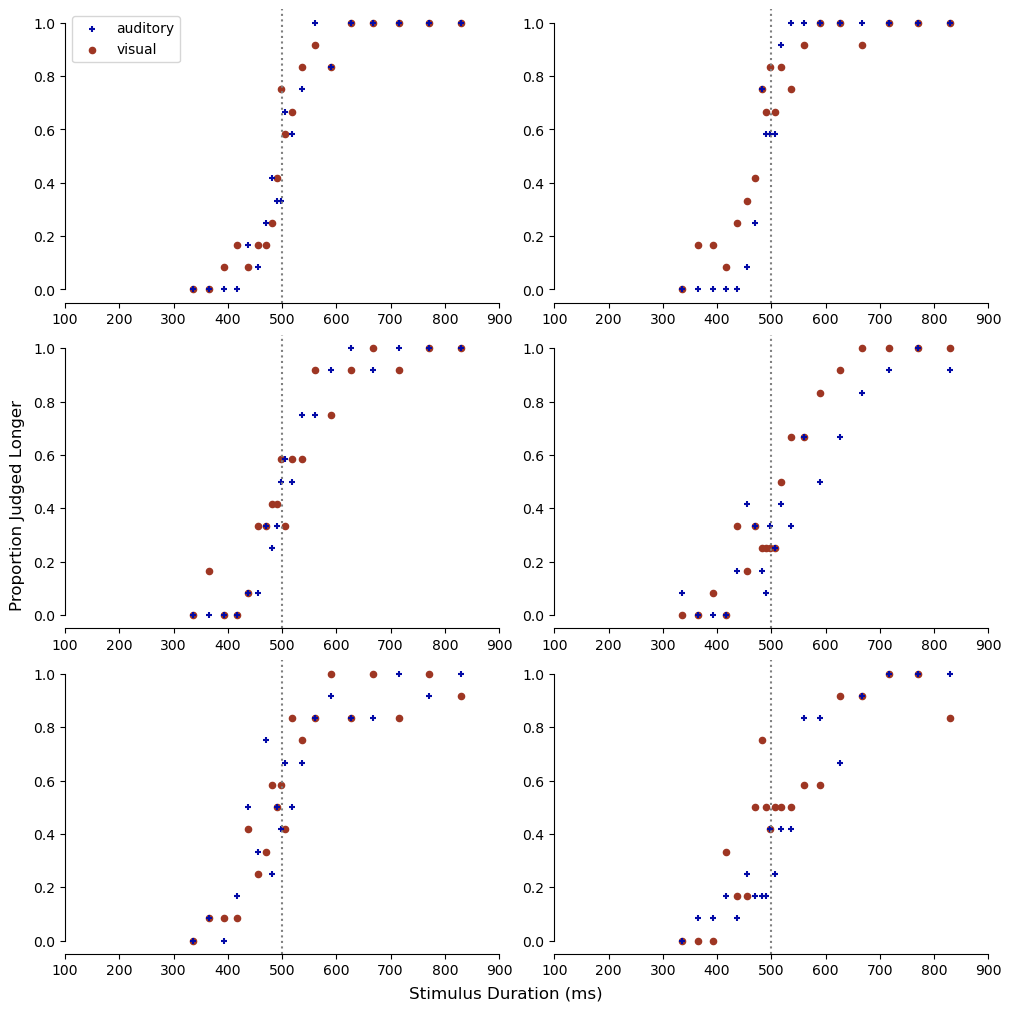

In [6]:
subjectList = np.array([7, 9, 15, 18, 6, 3]) # indices from matlab code on osf.id (subj A-F)
fig, ax = plt.subplots(3, 2, figsize=(10,10))
for idx, subj in enumerate(subjectList-1): # -1 to match matlab indexing
    get_subj_data(subj, df, 1, ax.flatten()[idx]);
fig.supxlabel('Stimulus Duration (ms)')
fig.supylabel('Proportion Judged Longer')
ax.flatten()[0].legend();

### Research Questions
(from the paper)
- How the brain integrates temporal information?
- What is the form of the psychophysical function? (Cauchy, logistic, Weibull, Gumbel and others)
- What parameterization best describes this function? Are there psychological interpretations?
- Are there individual differences? Qualitative (different functions) or quantitative (different parameter values)?
- Modality specificity?
- Sequential dependencies? Is the judgement on a trial (in)dependent on previous stimuli/responses?
- Are there contaminant repsonses? Do these affect other trials?

### Model Development

Stimulus-response functions:
1. Logistic function
$$
\theta = 1/{(1+\exp{(-\frac{x-s-\alpha}{\beta})})}
$$
2. Cauchy function
$$
\theta = \arctan{(\frac{x-s-\alpha}{\beta})}/\pi + \frac{1}{2}
$$
Probability of responding "longer" $\theta$, is dependent on the target stimulus length $x$, the standard stimulus length $s$, and parameters $\alpha$ and $\beta$.

In [7]:
def logistic_f(x, s, a, b):
    if b == 0:
        return 0
    else:
        return 1 / (1 + np.exp(-(x-s-a)/b))

def cauchy_f(x, s, a, b):
    if b == 0:
        return 0
    else:
        return np.arctan((x-s-a)/b)/np.pi + 0.5

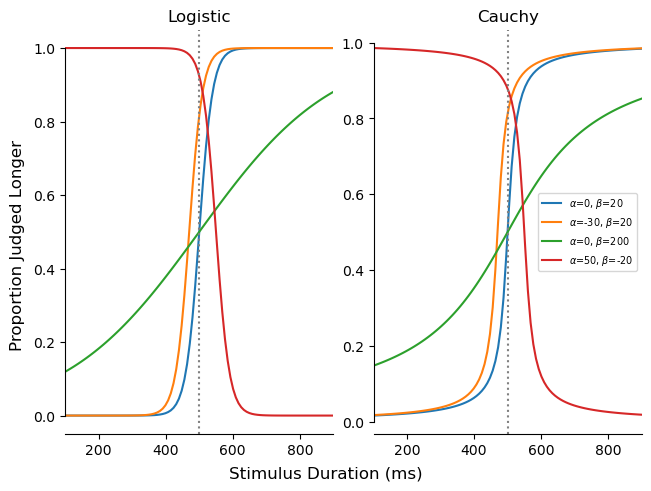

In [8]:
def plot_psychophysical_functions(parameter_set, predictor):
    fig, ax = plt.subplots(1, 2)
    for p in parameter_set:
        ax[0].plot(predictor, [logistic_f(x, 500, p[0], p[1]) for x in predictor])
        line, = ax[1].plot(predictor, [cauchy_f(x, 500, p[0], p[1]) for x in predictor])
        line.set_label(r'$\alpha$=' + str(p[0]) + r', $\beta$=' + str(p[1]))
    fig.supxlabel('Stimulus Duration (ms)')
    fig.supylabel('Proportion Judged Longer')

    titles = ['Logistic', 'Cauchy']
    for i in range(2):
        ax[i].axvline(x=500, color='gray', linestyle=':')
        ax[i].set_xlim([100, 900])
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['left'].set_bounds((0, 1))
        ax[i].spines['bottom'].set_bounds((100, 900))
        ax[i].set_title(titles[i])
    ax[1].legend(loc='right', fontsize='x-small');

parameter_set = np.array([[0, 20], [-30, 20], [0, 200], [50, -20]])
predictor = np.linspace(100, 900, 100)
plot_psychophysical_functions(parameter_set=parameter_set, predictor=predictor)

Notice the difference: Cauchy has fatter tails.

How different values of $\alpha$ and $\beta$ changes the function? Use the interactive widget below to see their effects:
- $\alpha$ shifts the function along x-axis
  - what happens when $\alpha > 0$, $\alpha < 0$, $\alpha = 0$? how do you interpret the increase/decrease in $|\alpha|$?
- $\beta$ adjusts the slope
  - what happens when $\beta > 0$, $\beta < 0$, $\beta = 0$? how do you interpret the increase/decrease in $|\beta|$?


In [9]:
def interactive_pp_plots(a=0, b=20):
    plot_psychophysical_functions(parameter_set=np.array([[a,b]]), predictor=np.linspace(100, 900, 100))

In [10]:
widgets.interact(interactive_pp_plots, a=(-200, 200, 1), b=(-200, 200, 1));

interactive(children=(IntSlider(value=0, description='a', max=200, min=-200), IntSlider(value=20, description=…

#### Informative Priors
Specifying priors:
- requires creative application of theory
- needs to incorporate previous data
- logical constraints should be considered
- assumption: joint prior distribution is the product of the marginal prior distributions for each parameter
- selective influence: the idea that experimental manipulations influnce just one parameter
- theoretically there is no reason for subjects to be biased towards responding either "longer" or "shorter": $\alpha$ should be centered at 0, it should be symmetric, and a 50ms of shift seems plausible (std dev)
$$
\alpha \sim \text{Gaussian}(0, 1/50^2)
$$
- for $\beta$, its clear that for longer durations we expect larger proportion of "longer" judgements, so $\beta>0$, and for the slope a std deviation of 100 seems plausible (see the demo above)
$$
\beta \sim \text{TruncatedGaussian}_{+}(0, 1/100^2)
$$
- other priors and likelihoods are possible “The bottom line... is that the choice of the prior is, just like any other modeling assumption in science, open to criticism.”
- btw, remember that $\sigma$: standard deviation, $\sigma^2$: variance, and $1/{\sigma^2}$: precision

In [11]:
def standardize(series):
    return (series - series.mean()) / series.std()

In [12]:
predictor_m1 = np.linspace(100, 900, 100)
selected_subj_data = df[(df['subj_id']==1) & (df['modality']=='visual')]
stim_durs = selected_subj_data['Stimulus'].unique()
trial_num_per_stim_dur = [len(selected_subj_data[selected_subj_data['Stimulus']==stimdur].index)
                            for stimdur in stim_durs]

In [13]:
selected_subj_data

,subj_id,modality,Stimulus,Decision,Accuracy
4800,1,visual,506,0.0,0.0
4801,1,visual,335,0.0,1.0
4802,1,visual,590,1.0,1.0
4803,1,visual,536,1.0,1.0
4804,1,visual,470,0.0,1.0
...,...,...,...,...,...
5035,1,visual,518,1.0,1.0
5036,1,visual,590,1.0,1.0
5037,1,visual,536,0.0,0.0
5038,1,visual,491,0.0,1.0


In [14]:
# !!! if dtype=unit, then you get problems.. if value <0 it assumes a value like 65533
# overflow errors may also be due to dtype inconsistencies!
# if not given as argument, dtype assumes uint16?!
x_data = selected_subj_data['Stimulus'].to_numpy(dtype=np.int64)
y_data = selected_subj_data['Decision'].to_numpy(dtype=np.int64)

with pm.Model() as m1:
    a = pm.Normal("alpha", mu=0, sigma=50)
    _b = pm.Normal.dist(mu=0, sigma=100)
    b = pm.Truncated("beta", _b, lower=0, upper=None) # try HalfNormal
    # b = pm.Normal("beta", mu=0, sigma=100) # allow for b<0
    t = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-(x_data-500-a)/b)))
    y = pm.Bernoulli("y", p=t, observed=y_data)
    idata = pm.sample_prior_predictive(samples=150, var_names=['alpha', 'beta', 'theta','y'])

Sampling: [alpha, beta, y]


In [15]:
aesara.dprint(t)

Elemwise{identity} [id A] 'theta'
 |Elemwise{true_div,no_inplace} [id B]
   |InplaceDimShuffle{x} [id C]
   | |TensorConstant{1} [id D]
   |Elemwise{add,no_inplace} [id E]
     |InplaceDimShuffle{x} [id F]
     | |TensorConstant{1} [id G]
     |Elemwise{exp,no_inplace} [id H]
       |Elemwise{true_div,no_inplace} [id I]
         |Elemwise{neg,no_inplace} [id J]
         | |Elemwise{sub,no_inplace} [id K]
         |   |TensorConstant{[   6 -165..  -9  -84]} [id L]
         |   |InplaceDimShuffle{x} [id M]
         |     |normal_rv{0, (0, 0), floatX, False}.1 [id N] 'alpha'
         |       |RandomGeneratorSharedVariable(<Generator(PCG64) at 0x17BA819E0>) [id O]
         |       |TensorConstant{[]} [id P]
         |       |TensorConstant{11} [id Q]
         |       |TensorConstant{0} [id R]
         |       |TensorConstant{50.0} [id S]
         |InplaceDimShuffle{x} [id T]
           |truncated_normal_rv{0, (0, 0, 0, 0), floatX, False}.1 [id U] 'beta'
             |RandomGeneratorSharedV

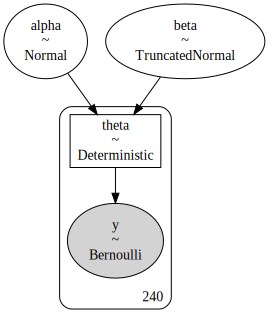

In [16]:
pm.model_to_graphviz(m1)

In [17]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

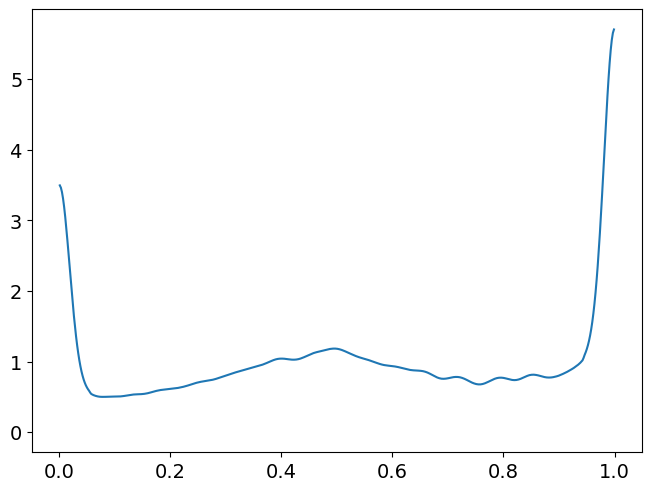

In [18]:
az.plot_dist(idata.prior.theta);

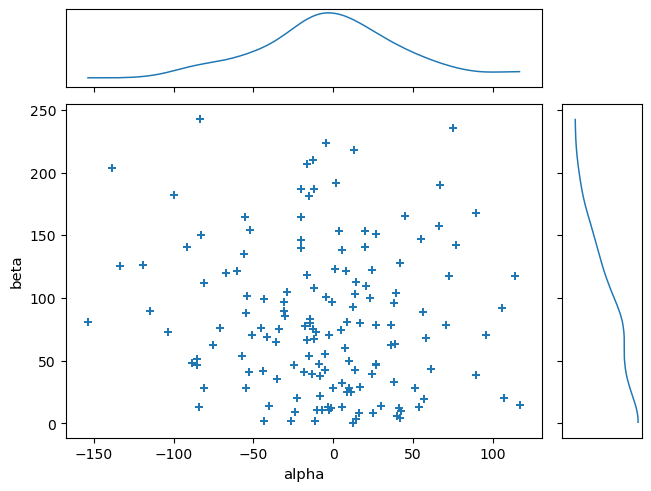

In [19]:
az.plot_pair(idata, marginals=True, textsize=10, group='prior', var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P' });

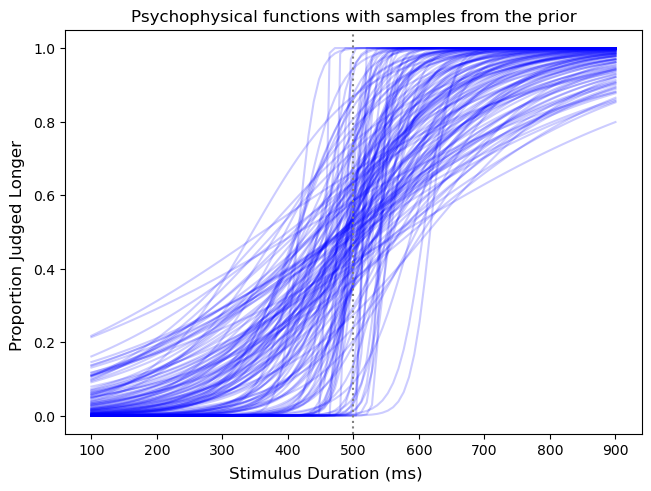

In [20]:
fig, ax = plt.subplots()
a_prior_samples = idata.prior.alpha.to_numpy()[0]
b_prior_samples = idata.prior.beta.to_numpy()[0]

for sample in np.arange(idata.prior.dims["draw"]):
    ax.plot(predictor_m1, [logistic_f(xi, 500, a_prior_samples[sample], b_prior_samples[sample]) for xi in predictor_m1], alpha=0.2, color='b')

fig.supxlabel('Stimulus Duration (ms)')
fig.supylabel('Proportion Judged Longer')
plt.title('Psychophysical functions with samples from the prior')
ax.axvline(x=500, color='gray', linestyle=':');

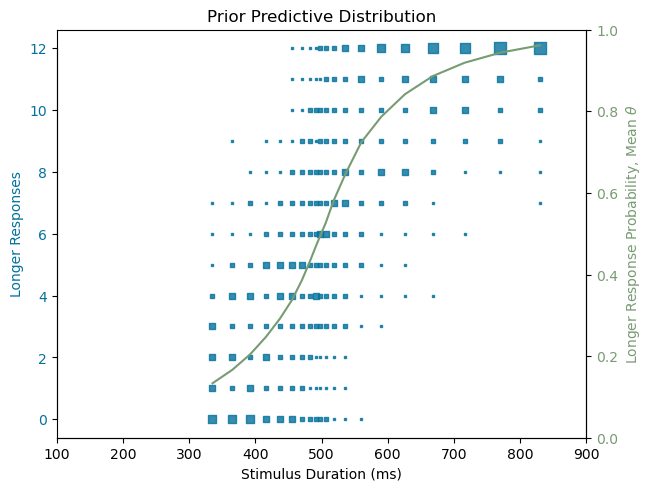

In [21]:
prior_predictive_y = np.squeeze(idata.prior_predictive.y.to_numpy())
thetas = np.squeeze(idata.prior.theta.to_numpy())
decision_count_pp = {}
prop_pp = {}
for stimdur in stim_durs: # 20 different stim durations
    data_indices = np.where(x_data == stimdur)[0] # 12 trials for each
    stimdur_specific_responses = np.sum(prior_predictive_y[:,data_indices], axis=1)
    count = np.histogram(stimdur_specific_responses, bins=np.arange(14))[0]
    decision_count_pp[stimdur] = count
    # what about thetas
    stimdur_specific_thetas = thetas[:,data_indices]
    mean_theta = np.mean(np.mean(stimdur_specific_thetas,axis=1))
    prop_pp[stimdur] = mean_theta

# pprint.pprint(prop_pp)
# pprint.pprint(decision_count_pp)

fig,ax1 = plt.subplots()
for key in decision_count_pp.keys():
    for countval in np.arange(13):
        countsize = decision_count_pp[key][countval]/150
        # print(key,countval)
        ax1.scatter(key, countval, s=countsize*100, c="xkcd:ocean blue", alpha=0.8, marker='s')
plt.xlim([100,900])
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_bounds((0, 12))
ax1.spines['bottom'].set_bounds((100, 900))
ax1.set_xlabel('Stimulus Duration (ms)')
ax1.set_ylabel('Longer Responses', color="xkcd:ocean blue")
ax1.tick_params(axis='y', labelcolor="xkcd:ocean blue")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
lists = sorted(prop_pp.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
ax2.plot(x, y, color="xkcd:grey green");
ax2.tick_params(axis='y', labelcolor="xkcd:grey green")
ax2.set_ylabel(r'Longer Response Probability, Mean $\theta$', color="xkcd:grey green")
ax2.set_ylim([0,1])
plt.title('Prior Predictive Distribution');

#### Vague Priors

Both parameters' priors are set with very low-precision Gaussian distributions which assign approximately equal probability to a wide range of values.
$$
\begin{align*}
\alpha &\sim \text{Gaussian}(0, 0.000001)
\\
\beta &\sim \text{Gaussian}(0, 0.000001)
\end{align*}
$$

In [22]:
with pm.Model() as m2:
    a = pm.Normal("alpha", mu=0, tau=0.000001)
    b = pm.Normal("beta", mu=0, tau=0.000001)
    t = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-(x_data-500-a)/b)))
    y = pm.Bernoulli("y", p=t, observed=y_data)
    idata_m2 = pm.sample_prior_predictive(samples=150, var_names=['alpha', 'beta', 'theta','y'])

Sampling: [alpha, beta, y]


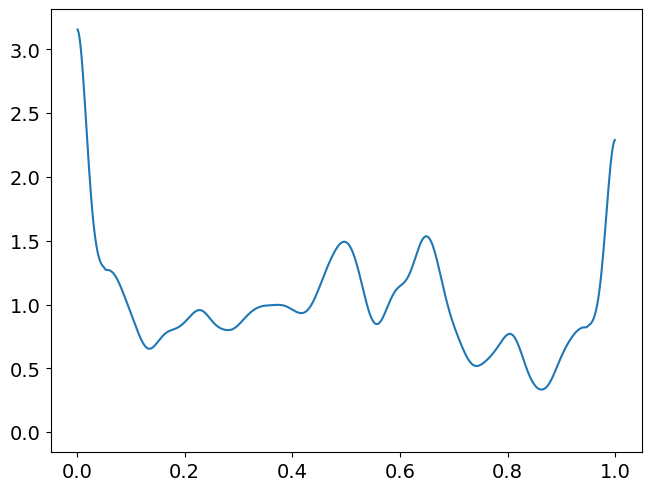

In [23]:
az.plot_dist(idata_m2.prior.theta);

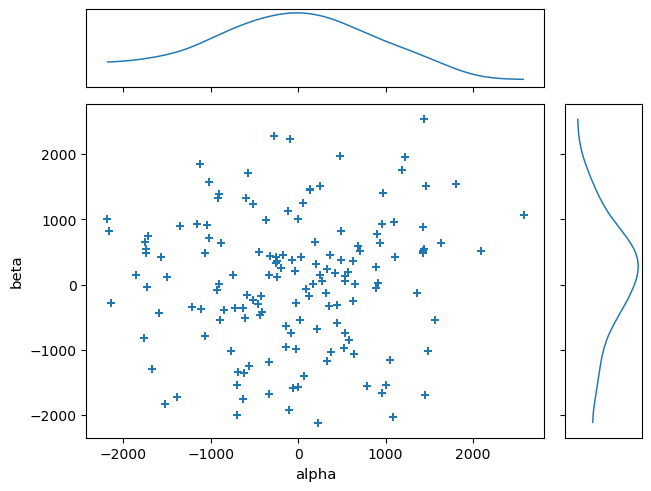

In [24]:
az.plot_pair(idata_m2, marginals=True, textsize=10, group='prior', var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P' });

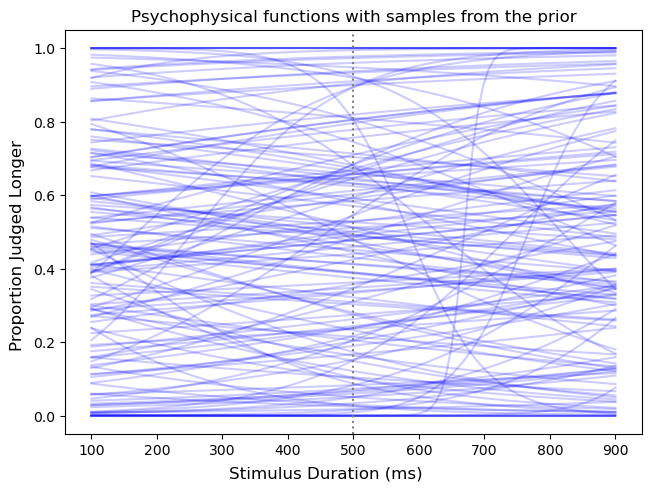

In [25]:
fig, ax = plt.subplots()
a_prior_samples = idata_m2.prior.alpha.to_numpy()[0]
b_prior_samples = idata_m2.prior.beta.to_numpy()[0]

for sample in np.arange(idata_m2.prior.dims["draw"]):
    ax.plot(predictor_m1, [logistic_f(xi, 500, a_prior_samples[sample], b_prior_samples[sample]) for xi in predictor_m1], alpha=0.2, color='b')

fig.supxlabel('Stimulus Duration (ms)')
fig.supylabel('Proportion Judged Longer')
plt.title('Psychophysical functions with samples from the prior')
ax.axvline(x=500, color='gray', linestyle=':');

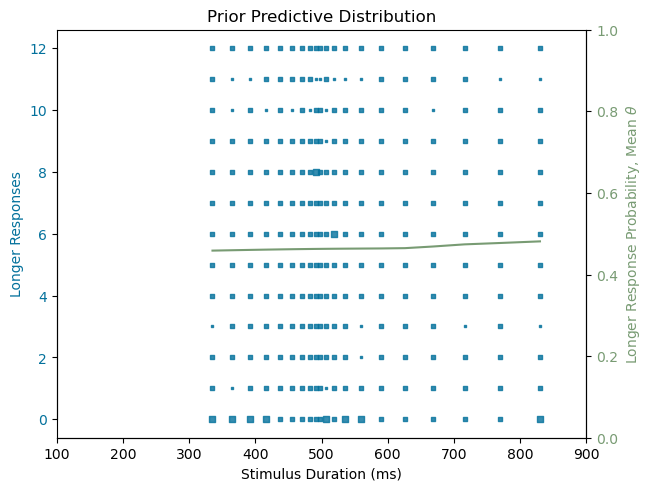

In [26]:
prior_predictive_y = np.squeeze(idata_m2.prior_predictive.y.to_numpy())
thetas = np.squeeze(idata_m2.prior.theta.to_numpy())
decision_count_pp = {}
prop_pp = {}
for stimdur in stim_durs: # 20 different stim durations
    data_indices = np.where(x_data == stimdur)[0] # 12 trials for each
    stimdur_specific_responses = np.sum(prior_predictive_y[:,data_indices], axis=1)
    count = np.histogram(stimdur_specific_responses, bins=np.arange(14))[0]
    decision_count_pp[stimdur] = count
    # what about thetas
    stimdur_specific_thetas = thetas[:,data_indices]
    mean_theta = np.mean(np.mean(stimdur_specific_thetas,axis=1))
    prop_pp[stimdur] = mean_theta

# pprint.pprint(prop_pp)
# pprint.pprint(decision_count_pp)

fig,ax1 = plt.subplots()
for key in decision_count_pp.keys():
    for countval in np.arange(13):
        countsize = decision_count_pp[key][countval]/150
        # print(key,countval)
        ax1.scatter(key, countval, s=countsize*100, c="xkcd:ocean blue", alpha=0.8, marker='s')
plt.xlim([100,900])
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_bounds((0, 12))
ax1.spines['bottom'].set_bounds((100, 900))
ax1.set_xlabel('Stimulus Duration (ms)')
ax1.set_ylabel('Longer Responses', color="xkcd:ocean blue")
ax1.tick_params(axis='y', labelcolor="xkcd:ocean blue")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
lists = sorted(prop_pp.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
ax2.plot(x, y, color="xkcd:grey green");
ax2.tick_params(axis='y', labelcolor="xkcd:grey green")
ax2.set_ylabel(r'Longer Response Probability, Mean $\theta$', color="xkcd:grey green")
ax2.set_ylim([0,1])
plt.title('Prior Predictive Distribution');

Vague prior, alternative parameterization:

In [27]:
with pm.Model() as m3:
    a = pm.Normal("alpha", mu=0, tau=0.000001)
    b = pm.Normal("beta", mu=0, tau=0.000001)
    t = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-b*(x_data-500-a))))
    y = pm.Bernoulli("y", p=t, observed=y_data)
    idata_m3 = pm.sample_prior_predictive(samples=150, var_names=['alpha', 'beta', 'theta','y'])

Sampling: [alpha, beta, y]


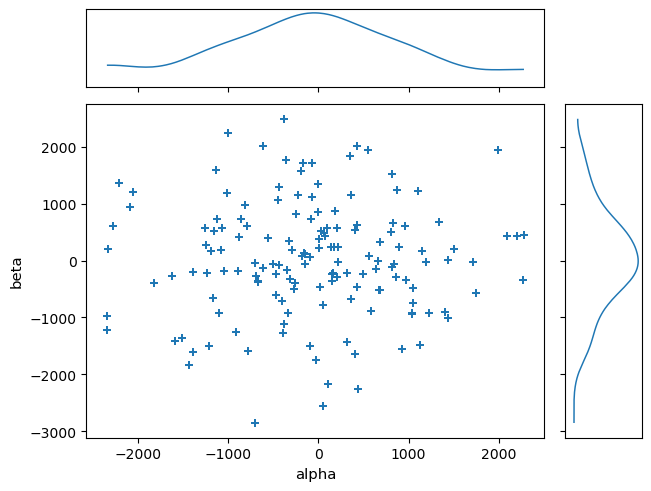

In [28]:
az.plot_pair(idata_m3, marginals=True, textsize=10, group='prior', var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P' });

/var/folders/_x/c00gpvvj08144m_76ng172dh0000gn/T/ipykernel_76330/2046949811.py:6: RuntimeWarning: overflow encountered in exp
  ax.plot(predictor_m1, [(1 / (1 + np.exp(-b_prior_samples[sample]*(xi-500-a_prior_samples[sample])))) for xi in predictor_m1], alpha=0.2, color='b')


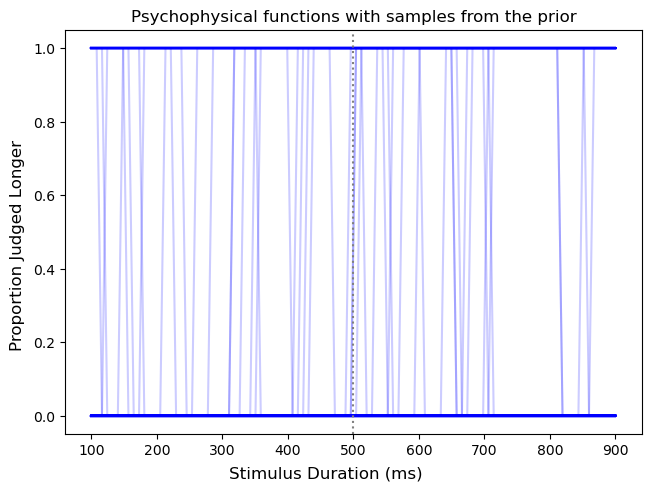

In [29]:
fig, ax = plt.subplots()
a_prior_samples = idata_m3.prior.alpha.to_numpy()[0]
b_prior_samples = idata_m3.prior.beta.to_numpy()[0]

for sample in np.arange(idata_m3.prior.dims["draw"]):
    ax.plot(predictor_m1, [(1 / (1 + np.exp(-b_prior_samples[sample]*(xi-500-a_prior_samples[sample])))) for xi in predictor_m1], alpha=0.2, color='b')

fig.supxlabel('Stimulus Duration (ms)')
fig.supylabel('Proportion Judged Longer')
plt.title('Psychophysical functions with samples from the prior')
ax.axvline(x=500, color='gray', linestyle=':');

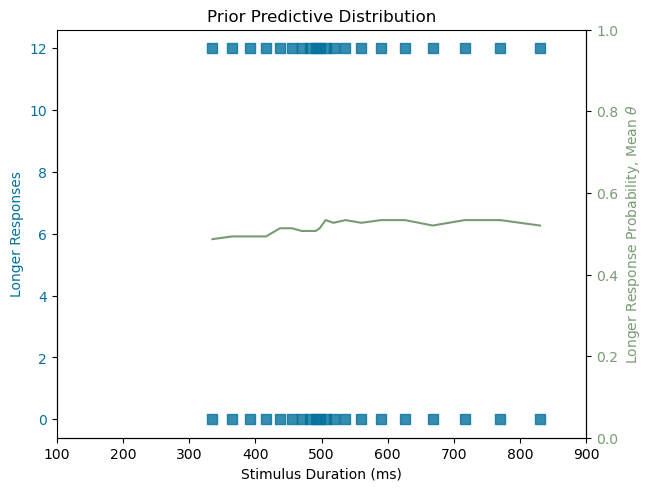

In [30]:
prior_predictive_y = np.squeeze(idata_m3.prior_predictive.y.to_numpy())
thetas = np.squeeze(idata_m3.prior.theta.to_numpy())
decision_count_pp = {}
prop_pp = {}
for stimdur in stim_durs: # 20 different stim durations
    data_indices = np.where(x_data == stimdur)[0] # 12 trials for each
    stimdur_specific_responses = np.sum(prior_predictive_y[:,data_indices], axis=1)
    count = np.histogram(stimdur_specific_responses, bins=np.arange(14))[0]
    decision_count_pp[stimdur] = count
    # what about thetas
    stimdur_specific_thetas = thetas[:,data_indices]
    mean_theta = np.mean(np.mean(stimdur_specific_thetas,axis=1))
    prop_pp[stimdur] = mean_theta

# pprint.pprint(prop_pp)
# pprint.pprint(decision_count_pp)

fig,ax1 = plt.subplots()
for key in decision_count_pp.keys():
    for countval in np.arange(13):
        countsize = decision_count_pp[key][countval]/150
        # print(key,countval)
        ax1.scatter(key, countval, s=countsize*100, c="xkcd:ocean blue", alpha=0.8, marker='s')
plt.xlim([100,900])
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_bounds((0, 12))
ax1.spines['bottom'].set_bounds((100, 900))
ax1.set_xlabel('Stimulus Duration (ms)')
ax1.set_ylabel('Longer Responses', color="xkcd:ocean blue")
ax1.tick_params(axis='y', labelcolor="xkcd:ocean blue")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
lists = sorted(prop_pp.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
ax2.plot(x, y, color="xkcd:grey green");
ax2.tick_params(axis='y', labelcolor="xkcd:grey green")
ax2.set_ylabel(r'Longer Response Probability, Mean $\theta$', color="xkcd:grey green")
ax2.set_ylim([0,1])
plt.title('Prior Predictive Distribution');

Note: Flat and uninformed priors are not the same thing!

### Inference

- Parameters $\alpha$ and $\beta$
- Data $y = (y_1, ..., y_T)$
- Model $M$ (the prior and likelihood)

Inference:
$$
p(\alpha, \beta | y, M) = \frac{p(y | \alpha, \beta, M)p(\alpha, \beta | M)}{p(y)}

In [31]:
subj_A = 6
selected_subj_data = df[(df['subj_id']==subj_A) & (df['modality']=='visual')]
decision_vals = selected_subj_data['Decision'].astype(np.dtype('float64')).values
nan_idx = np.where(np.isnan(decision_vals))
decision_vals[nan_idx] = 0
stim_dur_vals = selected_subj_data['Stimulus'].astype(np.dtype('float64')).values
x_data = stim_dur_vals.astype(np.int64)
y_data = decision_vals.astype(np.int64)

In [32]:
with pm.Model() as m4:
    a = pm.Normal("alpha", mu=0, sigma=50)
    _b = pm.Normal.dist(mu=0, sigma=100)
    b = pm.Truncated("beta", _b, lower=0, upper=None)
    # b = pm.HalfNormal("beta", mu=0, sigma=100) # try HalfNormal
    t = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-(x_data-500-a)/b)))
    y = pm.Bernoulli("y", p=t, observed=y_data)
    trace_m4 = pm.sample(6000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 2 seconds.


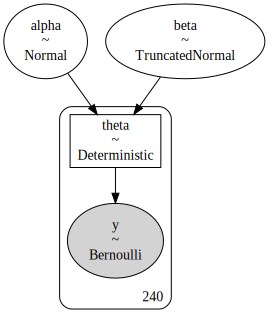

In [33]:
pm.model_to_graphviz(m4)

In [34]:
trace_m4

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [35]:
a = []
a.append(trace_m4.posterior.alpha[:, 1000:])
a.append(trace_m4.posterior.beta[:, 1000:])
post_m4 = xr.combine_by_coords(a)
post_m4

<xarray.Dataset>
Dimensions:  (chain: 3, draw: 5000)
Coordinates:
  * chain    (chain) int64 0 1 2
  * draw     (draw) int64 1000 1001 1002 1003 1004 ... 5995 5996 5997 5998 5999
Data variables:
    alpha    (chain, draw) float64 -8.583 -11.77 -2.92 ... -5.146 -10.53 -12.74
    beta     (chain, draw) float64 35.75 36.29 37.81 35.71 ... 35.96 34.76 34.22

#### Posterior Distributions

(0.0, 150.0)

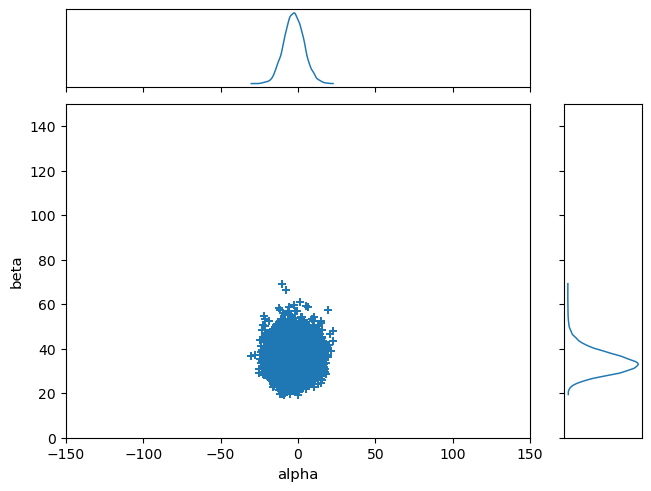

In [36]:
ax = az.plot_pair(post_m4, marginals=True, textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P'});
for i in np.arange(len(ax)):
    ax[i][0].set_xlim([-150, 150])
ax[1][0].set_ylim([0, 150])

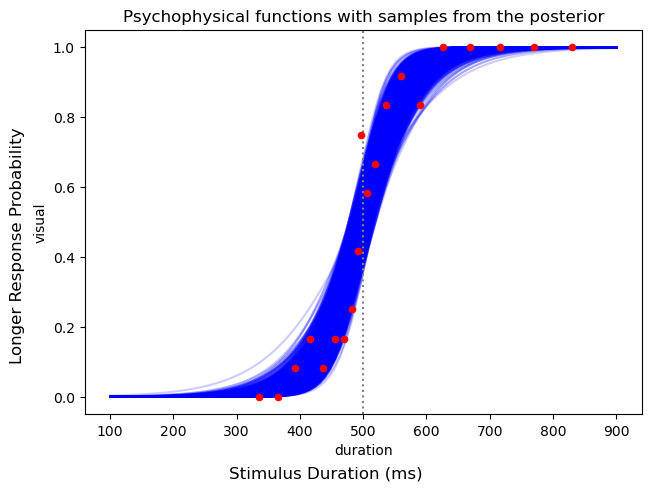

In [37]:
fig, ax = plt.subplots()
post_a = post_m4["alpha"].to_numpy().flatten()
post_b = post_m4["beta"].to_numpy().flatten()

for sample in np.arange(post_m4.dims["draw"]):
    ax.plot(predictor_m1, [logistic_f(xi, 500, post_a[sample], post_b[sample]) for xi in predictor_m1], alpha=0.2, color='b')

fig.supxlabel('Stimulus Duration (ms)')
fig.supylabel('Longer Response Probability')
plt.title('Psychophysical functions with samples from the posterior');
ax.axvline(x=500, color='gray', linestyle=':')

data_subj_A = get_subj_data(subj_A, df, 0)
data_subj_A.plot.scatter(x='duration', y='visual', ax=ax, c='r', zorder=100000);

#### Posterior Predictive Distribution

In [38]:
# adding 'alpha', 'beta', 'theta' to var_names changes results!
# but why would we add a&b as vars? that may be needed when we change the data, but thats not the case now.
with m4:
    pm.sample_posterior_predictive(trace_m4, extend_inferencedata=True, var_names=['y'])

Sampling: [y]


In [39]:
trace_m4

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

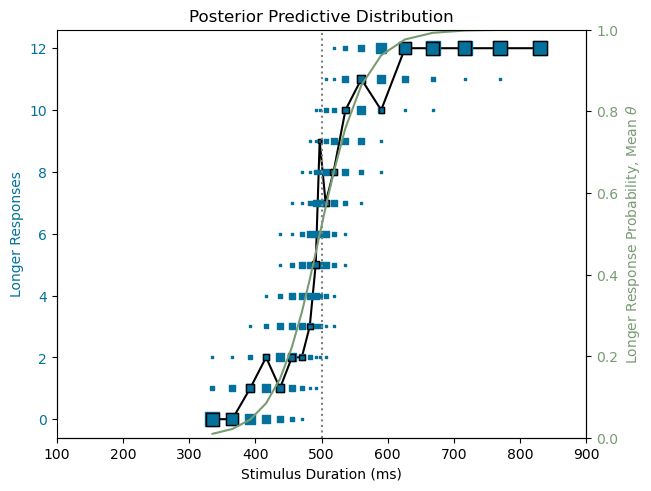

In [40]:
# prior_predictive_y = np.squeeze(idata.prior_predictive.y.to_numpy())
posterior_predictive_y = trace_m4.posterior_predictive.y.to_numpy()[:, 1000:, :].reshape(15000, 240)
thetas = trace_m4.posterior.theta.to_numpy()[:, 1000:, :].reshape(15000, 240)
decision_count_pp = {}
prop_pp = {}
for stimdur in stim_durs: # 20 different stim durations
    data_indices = np.where(x_data == stimdur)[0] # 12 trials for each
    stimdur_specific_responses = np.sum(posterior_predictive_y[:,data_indices], axis=1)
    count = np.histogram(stimdur_specific_responses, bins=np.arange(14))[0]
    decision_count_pp[stimdur] = count
    # what about thetas
    stimdur_specific_thetas = thetas[:,data_indices]
    mean_theta = np.mean(np.mean(stimdur_specific_thetas,axis=1))
    prop_pp[stimdur] = mean_theta

# pprint.pprint(prop_pp)
# pprint.pprint(decision_count_pp)

fig,ax1 = plt.subplots()
for key in decision_count_pp.keys():
    osb_countval = data_subj_A[data_subj_A['duration']==key]['visual'] * 12
    for countval in np.arange(13):
        countsize = decision_count_pp[key][countval] / np.sum(decision_count_pp[key])
        ax1.scatter(key, countval, s=countsize*100, c="xkcd:ocean blue", marker='s')
        if osb_countval.values[0] == countval:
            ax1.scatter(key, countval, s=countsize*100, facecolors='none', edgecolors='k', marker='s', label=None)

data_subj_A['visual_counts'] = data_subj_A['visual']*12
data_subj_A.plot(x='duration',y='visual_counts', color='k', ax=ax1, zorder=0, label=None)

plt.xlim([100,900])
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_bounds((0, 12))
ax1.spines['bottom'].set_bounds((100, 900))
ax1.set_xlabel('Stimulus Duration (ms)')
ax1.set_ylabel('Longer Responses', color="xkcd:ocean blue")
ax1.tick_params(axis='y', labelcolor="xkcd:ocean blue")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
lists = sorted(prop_pp.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
ax2.plot(x, y, color="xkcd:grey green");
ax2.tick_params(axis='y', labelcolor="xkcd:grey green")
ax2.set_ylabel(r'Longer Response Probability, Mean $\theta$', color="xkcd:grey green")
ax2.set_ylim([0,1])
plt.title('Posterior Predictive Distribution');
ax1.axvline(x=500, color='gray', linestyle=':');
ax1.get_legend().remove();

# idk why, sometimes i get a different result (with data scattered more, like it's not a posterior)
# it happens when i include other parameters in the sample_posterior argument var_names (the more parameters i add,
# the more spread the plot gets!! is this expected!?)

#### Summarizing the Posterior Distribution

Given a model:
- likelihood function for generating data
- priors over the parameters of the likelihood
- observed data

Applying the Bayes' rule defines a *joint* posterior distribution over the parameters.

Summarizing the posterior:
- marginal posterior distributions for each parameter (loss of information in the joint distribution that is different from the independent product of the marginals)
- mean, standard deviation
- credible interval (hdi)
- percentiles (areas under distributions can be interpreted as probabilities)
- relative densities can be interpreted as likelihood ratios

In [41]:
az.summary(trace_m4, var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-2.646,6.477,-14.408,9.986,0.048,0.046,18118.0,11923.0,1.0


In [42]:
print("2.5% percentile to 97.5% percentile of the distribution:")
print(trace_m4.posterior.alpha.quantile(0.025).to_numpy())
print(trace_m4.posterior.alpha.quantile(0.975).to_numpy())

2.5% percentile to 97.5% percentile of the distribution:
-15.13046473736887
10.310272854003264


In [43]:
alpha_values = trace_m4.posterior['alpha'][:, 1000:].to_numpy().flatten()
az.hdi(alpha_values, hdi_prob=0.95)

array([-14.85130507,  10.55921904])

The probability that the shift of the psychophysical function is negative — that is, to the left — and more extreme than 5 ms is:

In [44]:
def find_idx_of_closest_value(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

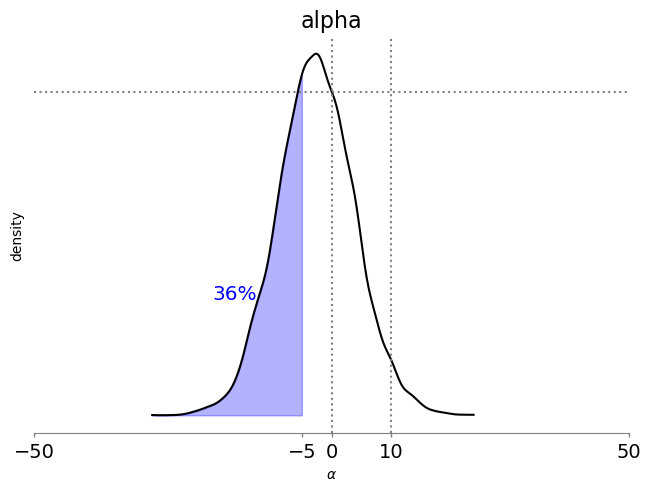

In [45]:
ax = az.plot_posterior(trace_m4, var_names=["alpha"], color='k',
             hdi_prob='hide', point_estimate=None) # we can also use ref_val=-5

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel("density")

alpha_thresholded = alpha_values[alpha_values <= -5]
prob_under_area = len(alpha_thresholded) / len(alpha_values)

l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
ax.fill_between(x1[x1<-5],y1[x1<-5], color="blue", alpha=0.3)
ax.text(-20,0.02,"{0:.0f}%".format(prob_under_area * 100), color = "blue", fontsize= "x-large");
ax.axvline(x=0, color='gray', linestyle=':');
ax.axvline(x=10, color='gray', linestyle=':');
ax.axhline(y=y1[find_idx_of_closest_value(x1, 0)], color='gray', linestyle=':');
ax.set_xlim([-50, 50]);
ax.set_xticks([-50, -5, 0, 10, 50]);

"Relative densities can be interpreted as likelihood ratios": Likelihood ratio of alpha = 0 vs alpha = 10:

In [46]:
y1[find_idx_of_closest_value(x1, 0)] / y1[find_idx_of_closest_value(x1, 10)]
# not sure if p(a<-5)=0.36, LR(a=0/a=10)=6.27 (values are slightly different in the paper: 38% and 7)

5.821569444901882

### Model Testing

#### Bayes Factor

Quantification of the relative evidence that data provide for two models: $M_a$ and $M_b$ as the ratio:

$$
BF_{ab} = \frac{p(y|M_a)}{p(y|M_b)}
$$

which is similar to a likelihood ratio where models are allowed to have parameters.

It is possible to used the Savage-Dickey method when one of the models is a special case of the other: the Bayes factor is the ratio of the prior and posterior at the point in the parameter space that reduces the full model to the nested model. With SD method it is possible to test nested models that require more than one parameter to take specific values.

Bayes factor in favor of the nested model for alpha
6.295863014817842
Bayes factor in favor of the general model for beta
19.870435840355185


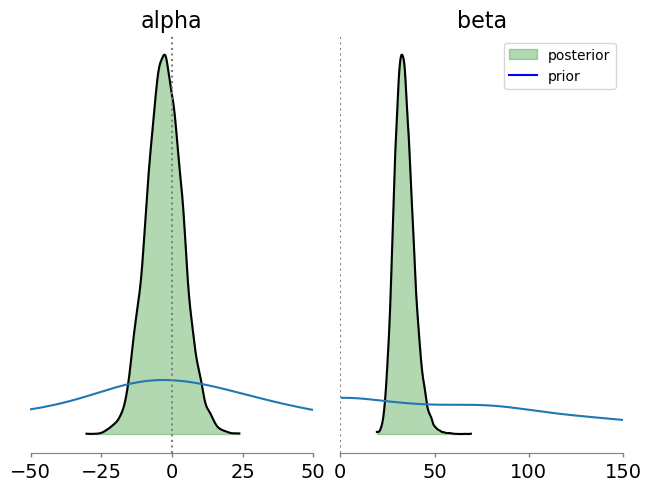

In [47]:
fig, ax = plt.subplots(1, 2)
az.plot_posterior(trace_m4, var_names=["alpha"], color='k', hdi_prob='hide', point_estimate=None, group='posterior', ax=ax[0], backend_kwargs={'label':'posterior'})
l1 = ax[0].lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
post_density_a_0 = y1[find_idx_of_closest_value(x1, 0)]
ax[0].fill_between(x1, y1, color="green", alpha=0.3)
az.plot_posterior(idata.prior.alpha, group='prior',  hdi_prob='hide', point_estimate=None, ax=ax[0], backend_kwargs={'label':'prior'})
l1 = ax[0].lines[1]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
prior_density_a_0 = y1[find_idx_of_closest_value(x1, 0)]
ax[0].set_xlim([-50, 50])
print("Bayes factor in favor of the nested model for alpha")
print(post_density_a_0/prior_density_a_0)

az.plot_posterior(trace_m4, var_names=["beta"], color='k', hdi_prob='hide', point_estimate=None, group='posterior', ax=ax[1], backend_kwargs={'label':'posterior'})
l1 = ax[1].lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
post_density_b_0 = y1[find_idx_of_closest_value(x1, 0)]
ax[1].fill_between(x1, y1, color="green", alpha=0.3)
az.plot_posterior(idata.prior.beta, group='prior',  hdi_prob='hide', point_estimate=None, ax=ax[1], backend_kwargs={'label':'prior'})
ax[1].set_xlim([0, 150])
l1 = ax[0].lines[1]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
prior_density_b_0 = y1[find_idx_of_closest_value(x1, 0)]

print("Bayes factor in favor of the general model for beta")
print(prior_density_b_0/post_density_b_0)

green_patch = mpatches.Patch(color='green', label='posterior', alpha=0.3)
blue_patch = mlines.Line2D([],[], color='blue', label='prior')

ax[0].axvline(x=0, color='gray', linestyle=':')
ax[1].axvline(x=0, color='gray', linestyle=':')

plt.legend(handles=[green_patch, blue_patch]);

#### Sensitivity Analysis

- The theory may not be strong or complete or precise enough.
- Some parts of most models are based on assumptions, but not strong theoretical commitments.
- How sensitive the results of inferences based on the model are with respect to these noncore assumptions? The sort of inferences are: posterior distributions, posterior predictives, Bayes factors, or a measure/feature that is important for making conclusions about the problem at hand. 
- The priors in this model has some arbitrariness in their development. We can have a look at the joint posterior distribution for $\alpha$ and $\beta$ by changing prior distribution's $\sigma$ for $\alpha$ from 50 to 100, and $\sigma$ for $\beta$ from 100 to 200.
- The likelihood component of a model is also based on simplifying assumptions, which needs to be checked for model sensitivity. The models up to this point did not consider sequential effects (i.e. the S-R relationship was assumed to be based only on the context of the current trial, but it is possible that previous trials may effect the decisions at the current trial)

##### Sensitivity Based on Priors


In [48]:
with pm.Model() as m4_s1:
    a = pm.Normal("alpha", mu=0, sigma=100)
    _b = pm.Normal.dist(mu=0, sigma=100)
    b = pm.Truncated("beta", _b, lower=0, upper=None)
    t = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-(x_data-500-a)/b)))
    y = pm.Bernoulli("y", p=t, observed=y_data)
    trace_m4_s1 = pm.sample(6000, chains=3)

with pm.Model() as m4_s2:
    a = pm.Normal("alpha", mu=0, sigma=50)
    _b = pm.Normal.dist(mu=0, sigma=200)
    b = pm.Truncated("beta", _b, lower=0, upper=None)
    t = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-(x_data-500-a)/b)))
    y = pm.Bernoulli("y", p=t, observed=y_data)
    trace_m4_s2 = pm.sample(6000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 3 seconds.


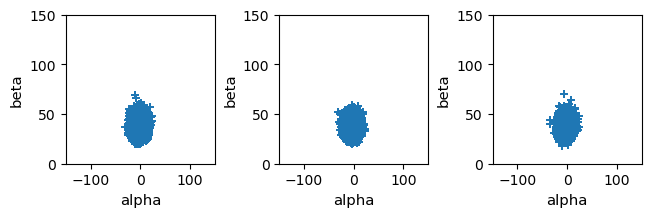

In [49]:
fig, ax = plt.subplots(1,3)

az.plot_pair(post_m4, marginals=False, textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P'}, ax=ax[0]);

a = []
a.append(trace_m4_s1.posterior.alpha[:, 1000:])
a.append(trace_m4_s1.posterior.beta[:, 1000:])
post_m4_s1 = xr.combine_by_coords(a)
az.plot_pair(post_m4_s1, marginals=False, textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P'}, ax=ax[1]);

a = []
a.append(trace_m4_s2.posterior.alpha[:, 1000:])
a.append(trace_m4_s2.posterior.beta[:, 1000:])
post_m4_s2 = xr.combine_by_coords(a)
az.plot_pair(post_m4_s2, marginals=False, textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P'}, ax=ax[2]);

for i in np.arange(len(ax)):
    ax[i].set_xlim([-150, 150])
    ax[i].set_ylim([0, 150])
    ax[i].set_box_aspect(1)

Joint distributions turn out to be similar, so results regarding inference are not likely to be sensitive to the exact form of the priors.

##### Sensitivity Based on Likelihood

In this section we need to introduce a new model where the subject's response on the previous trial affects the response probability on the current trial.

This is formalized as follows. There is a change, $\epsilon$, in the probability of responding 'longer' at time step $t$ ($\theta_{t}$) based on the previous decision ($y_{t-1}$). The signs of $\epsilon s$ in likelihood is different, 'shorter' leads to a change in one direction and 'longer' leads to a change in the opposite direction. But the prior for $\epsilon$ is a Gaussian which permits either increase or decrease in the rate for both type of decisions.

$$
\begin{align*}
\alpha &\sim \text{Gaussian}(0, 1/50^2)
\\
\beta &\sim \text{TruncatedGaussian}_{+}(0, 1/100^2)
\\
\epsilon &\sim \text{Gaussian}(0, 1/0.1^2)
\\
\theta_t &=
\left\{ 
  \begin{array}{ c l }
    1/{(1+\exp{(-\frac{x-s-\alpha}{\beta})})} + \epsilon & \quad \textrm{if } y_{t-1} = 0, t > 1 \\
    1/{(1+\exp{(-\frac{x-s-\alpha}{\beta})})} - \epsilon & \quad \textrm{if } y_{t-1} = 1, t > 1 \\
  \end{array}
\right.
\\
y_{t} &\sim \text{Bernoulli}(\theta_t)
\end{align*}
$$

In [50]:
# some modifications for the case t=1, ie. no previous decision
y_data_prev = np.ones(y_data.shape[0])*-1
y_data_prev[1:] = y_data[:-1]
y_data_prev = y_data_prev.astype(np.int64)

In [51]:
# there seems to be a problem with this model? what happens when theta_t is out of range [0,1]
# even more pymc.Bernoulli does not accept p=0 or p=1 too
# maybe we could add a term to the main term and then take the invlogit (sigmoid)

with pm.Model() as m_seq:
    # priors
    a = pm.Normal("alpha", mu=0, sigma=50)
    _b = pm.Normal.dist(mu=0, sigma=100)
    b = pm.Truncated("beta", _b, lower=0, upper=None)
    e = pm.Normal("epsilon", 0, 0.1)
    
    #likelihood
    main_term = pm.Deterministic("main_term", 1 / (1 + pm.math.exp(-(x_data-500-a)/b)))  
    # add/subtract epsilon based on y_prev
    term_w_eps = pm.Deterministic("term_w_eps", at.switch(at.eq(y_data_prev, -1), main_term, at.switch(at.eq(y_data_prev, 0), main_term + e, main_term - e)))
    # clean up the values that are out of [0, 1] range
    theta = pm.Deterministic("theta", at.switch(at.le(term_w_eps, 0), 0.000001, at.switch(at.ge(term_w_eps, 1), 0.999999, term_w_eps)))

    # outcome
    y = pm.Bernoulli("y", p=theta, observed=y_data)

    # samples
    priors_seq = pm.sample_prior_predictive(samples=150, var_names=['alpha', 'beta', 'epsilon'])
    trace_m_seq = pm.sample(6000, chains=3)

Sampling: [alpha, beta, epsilon]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 4 seconds.


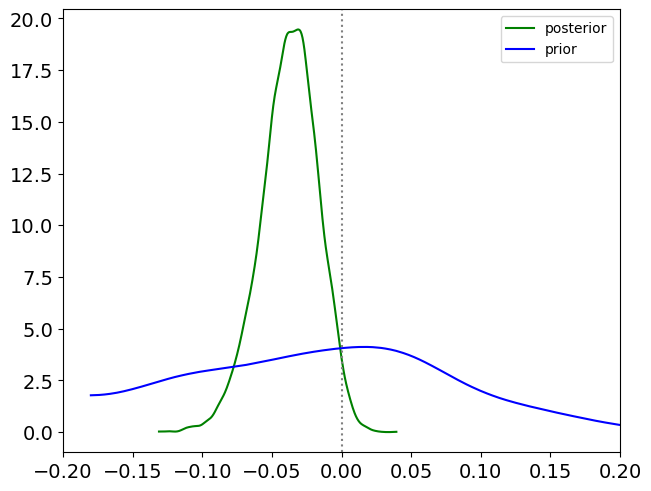

In [52]:
ax=az.plot_dist(trace_m_seq.posterior.epsilon, color="green")
ax=az.plot_dist(priors_seq.prior.epsilon, color='blue')
ax.axvline(x=0, color='gray', linestyle=':')
plt.legend(handles=[mlines.Line2D([],[], color='green', label='posterior'), mlines.Line2D([],[], color='blue', label='prior')])
ax.set_xlim([-0.2, 0.2]);

(0.0, 150.0)

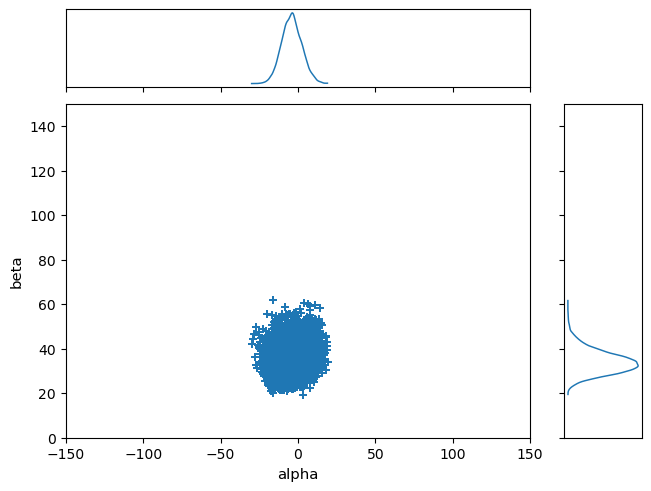

In [53]:
ax = az.plot_pair(trace_m_seq, marginals=True, textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P'});
for i in np.arange(len(ax)):
    ax[i][0].set_xlim([-150, 150])
ax[1][0].set_ylim([0, 150])

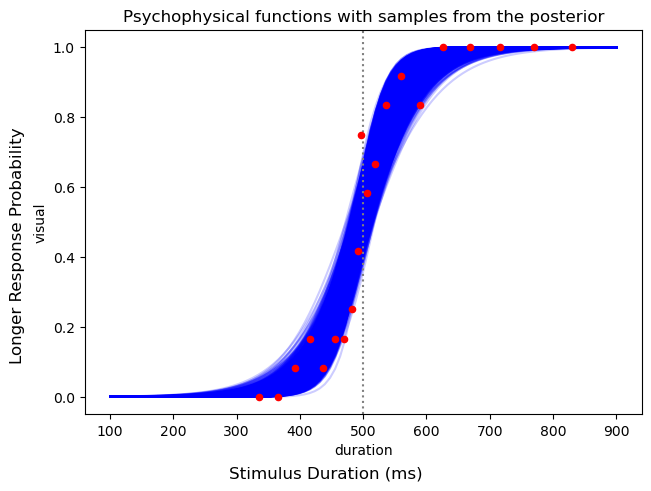

In [54]:
fig, ax = plt.subplots()
post_a = trace_m_seq.posterior["alpha"].to_numpy().flatten()
post_b = trace_m_seq.posterior["beta"].to_numpy().flatten()

for sample in np.arange(trace_m_seq.posterior.dims["draw"]):
    ax.plot(predictor_m1, [logistic_f(xi, 500, post_a[sample], post_b[sample]) for xi in predictor_m1], alpha=0.2, color='b')

fig.supxlabel('Stimulus Duration (ms)')
fig.supylabel('Longer Response Probability')
plt.title('Psychophysical functions with samples from the posterior');
ax.axvline(x=500, color='gray', linestyle=':')

data_subj_A = get_subj_data(subj_A, df, 0)
data_subj_A.plot.scatter(x='duration', y='visual', ax=ax, c='r', zorder=100000);

In [55]:
# now with epsilon in the term before taking its sigmoid

with pm.Model() as m_seq:
    # priors
    a = pm.Normal("alpha", mu=0, sigma=50)
    _b = pm.Normal.dist(mu=0, sigma=100)
    b = pm.Truncated("beta", _b, lower=0, upper=None)
    e = pm.Normal("epsilon", 0, 1)
    
    #likelihood
    main_term = pm.Deterministic("main_term", (x_data-500-a)/b)  
    # add/subtract epsilon based on y_prev
    # btw changing which condition gets +e or -e seems to change the shift in the E[posterior.epsilon!]
    # if for the case when y_(t-1) is 0 we set +e the posterior seems to shift left (-e for the other case)
    # if for the case when y_(t-1) is 1 we set +e the posterior seems to shift right (-e for the other case)
    # see the diff in epsilon sigma=0.1 and sigma=10 (since we changed space of epsilon compared to the original model)
    # removing the case for t=1 also dont change anything
    # term_w_eps = pm.Deterministic("term_w_eps", at.switch(at.eq(y_data_prev, 0), main_term - e, main_term + e))
    term_w_eps = pm.Deterministic("term_w_eps", at.switch(at.eq(y_data_prev, -1), main_term, at.switch(at.eq(y_data_prev, 0), main_term + e, main_term - e)))
    
    # sigmoid
    theta = pm.Deterministic("theta", pm.invlogit(term_w_eps))

    # outcome
    y = pm.Bernoulli("y", p=theta, observed=y_data)

    # samples
    priors_seq = pm.sample_prior_predictive(samples=150, var_names=['alpha', 'beta', 'epsilon', 'main_term'])
    trace_m_seq = pm.sample(6000, chains=3)

Sampling: [alpha, beta, epsilon]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 3 seconds.


Bayes factor (prior/posterior at eps=0):
3.000750787997363


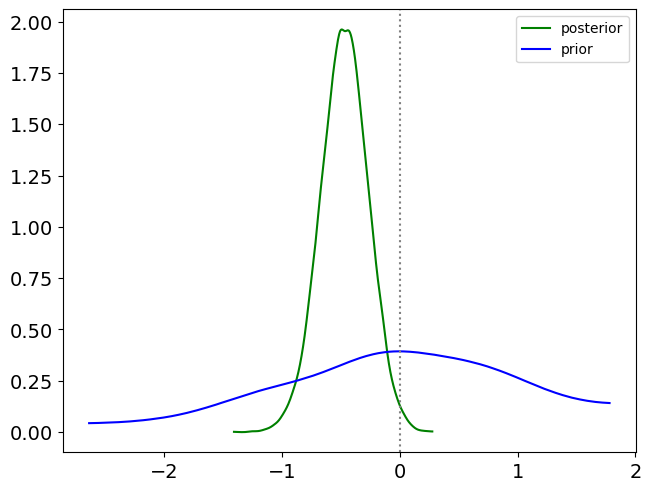

In [56]:
ax=az.plot_dist(trace_m_seq.posterior.epsilon, color="green")
l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
post_density_eps = y1[find_idx_of_closest_value(x1, 0)]
ax=az.plot_dist(priors_seq.prior.epsilon, color='blue')
l1 = ax.lines[1]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
prior_density_eps = y1[find_idx_of_closest_value(x1, 0)]
ax.axvline(x=0, color='gray', linestyle=':')
plt.legend(handles=[mlines.Line2D([],[], color='green', label='posterior'), mlines.Line2D([],[], color='blue', label='prior')]);
# ax.set_xlim([-0.2, 0.2]);
print("Bayes factor (prior/posterior at eps=0):")
print(prior_density_eps/post_density_eps)

Results:
- The paper shows a Bayes factor of ~10 against the presence of sequential effects at $\epsilon = 0$.
- I couldn't replicate this result, there seems to be shift in the $E[\epsilon]$ value in a direction based on the sign of the $\epsilon$ term in the likelihood.
- My results shows a Bayes factor of ~3 in favor of the presence of sequential effects.
- Can we say that this suggests presence of sequential effects such that if the previous decision is 'shorter' (i.e. $y_{t-1}=0$), then there is a decrease in the probability of responding 'longer' in the current trial. Similarly, if the previous decision was 'longer' then we get a increase in the probability of responding 'longer' in the current trial.

Model Comparison and Sensitivity Analyses:
- When we modify a prior or likelihood, we actually do inference with a different model
- However, all those models are consistent with a single theory about the phenomenon
- In model comparison the aim is to compare different theoretical assumptions

### Latent-Mixture Modeling

#### Contaminant Trials

When a subject attends an experiment they probably do not always use the same cognitive processes at each trial. Using latent-mixture models we can extend the model to account for contaminant processes.

Model modification. Now a decision can be made based on the following:
- the pschophysical function that we considered up to now
- a contaminant process based on a base rate, which is an unknown parameter $\psi$ where decision is a Bernoulli trial with that rate $\theta^c_t \sim \text{Bernoulli}(\psi)$
- there has to be a control mechanism which dictates which decision process to use, and this can be another Bernoulli trial based on another parameter ($\phi$ and $z_t$), also called a binary indicator variable 

$$
\begin{align*}
\alpha &\sim \text{Gaussian}(0, 1/50^2)
\\
\beta &\sim \text{TruncatedGaussian}_{+}(0, 1/100^2)
\\
\theta^l_t &= 1/{(1+\exp{(-\frac{x-s-\alpha}{\beta})})} 
\\
\psi &\sim \text{Uniform}(0, 1)
\\
\theta^c_t &\sim \text{Bernoulli}(\psi)
\\
\phi &\sim \text{Uniform}(0, 1)
\\
z_t &\sim \text{Bernoulli}(\phi)
\\
\theta_t &=
\left\{ 
  \begin{array}{ c l }
    \theta^l_t & \textrm{if } z_t = 0 \\
    \theta^c_t & \textrm{if } z_t = 1 \\
  \end{array}
\right.
\\
y_{t} &\sim \text{Bernoulli}(\theta_t)
\end{align*}
$$

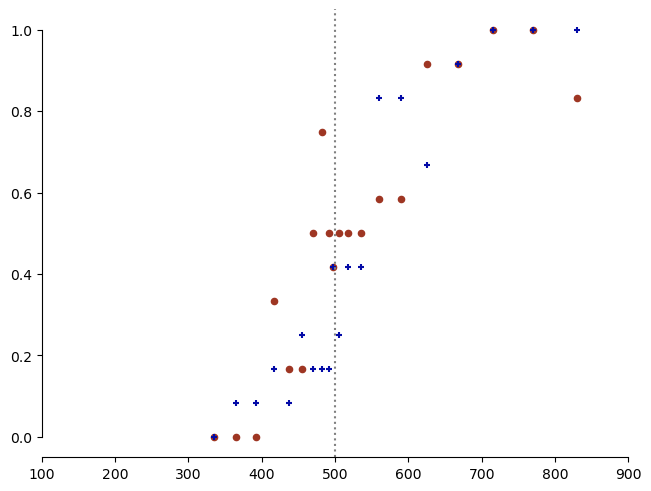

In [57]:
# in this section another subject's data is used
# it is subject F with id 3-1=2 (matlab idx correction)
fig, ax = plt.subplots()
subj_F_data = get_subj_data(2, df, 1, ax)

In [58]:
subj_F = 2
subj_F_data = df[(df['subj_id']==subj_F) & (df['modality']=='visual')]
decision_vals = subj_F_data['Decision'].astype(np.dtype('float64')).values
nan_idx = np.where(np.isnan(decision_vals))
decision_vals[nan_idx] = 0
stim_dur_vals = subj_F_data['Stimulus'].astype(np.dtype('float64')).values
x_data_lmm = stim_dur_vals.astype(np.int64)
y_data_lmm = decision_vals.astype(np.int64)

In [59]:
with pm.Model() as lmm:
    # priors
    a = pm.Normal("alpha", mu=0, sigma=50)
    _b = pm.Normal.dist(mu=0, sigma=100)
    b = pm.Truncated("beta", _b, lower=0, upper=None)
    t_l = pm.Deterministic("theta_l", pm.invlogit((x_data_lmm - 500 - a)/b))
    # contaminant process
    psi = pm.Uniform("psi", 0, 1)
    t_c = pm.Bernoulli("theta_c", p=psi, shape=x_data_lmm.shape[0])
    # control parameter
    phi = pm.Uniform("phi", 0, 1)
    z_t = pm.Bernoulli("z_t", p=phi, shape=x_data_lmm.shape[0])
    # strategy at trial t
    t_ = at.switch(at.eq(z_t, 0), t_l, t_c)
    # 0 and 1 are not allowed in pm.Bernoulli
    t = pm.Deterministic("theta", at.switch(at.le(t_, 0), 0.000001, at.switch(at.ge(t_, 1), 0.999999, t_)))
    y = pm.Bernoulli("y", p=t, observed=y_data_lmm)
    trace_lmm = pm.sample(6000, chains=3) #initvals={'alpha':0, 'beta':10, 'psi': 0.5, 'phi':0.5}

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, beta, psi, phi]
>BinaryGibbsMetropolis: [theta_c, z_t]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 140 seconds.


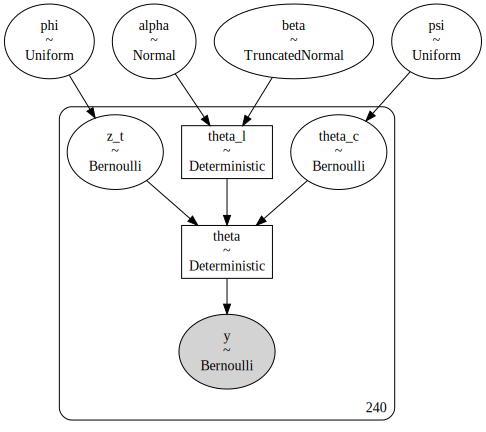

In [60]:
pm.model_to_graphviz(lmm)

In [61]:
trace_lmm

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [62]:
trace_lmm_burnin_ = []
trace_lmm_burnin_.append(trace_lmm.posterior.alpha[:, 1000:])
trace_lmm_burnin_.append(trace_lmm.posterior.beta[:, 1000:])
trace_lmm_burnin_.append(trace_lmm.posterior.psi[:, 1000:])
trace_lmm_burnin_.append(trace_lmm.posterior.phi[:, 1000:])
trace_lmm_burnin = xr.combine_by_coords(trace_lmm_burnin_)
trace_lmm_burnin

<xarray.Dataset>
Dimensions:  (chain: 3, draw: 5000)
Coordinates:
  * chain    (chain) int64 0 1 2
  * draw     (draw) int64 1000 1001 1002 1003 1004 ... 5995 5996 5997 5998 5999
Data variables:
    alpha    (chain, draw) float64 30.43 29.67 33.34 31.18 ... 1.5 14.26 14.26
    beta     (chain, draw) float64 73.35 72.06 59.91 61.03 ... 53.5 47.84 47.84
    phi      (chain, draw) float64 0.06055 0.07226 0.09722 ... 0.208 0.208
    psi      (chain, draw) float64 0.5641 0.5844 0.6117 ... 0.4195 0.4601 0.4601

In [63]:
az.summary(trace_lmm, var_names=['alpha','beta', 'phi', 'psi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.333,13.652,-20.585,30.533,0.656,0.464,434.0,1085.0,1.00
beta,58.312,11.732,37.028,79.682,0.419,0.297,806.0,1355.0,1.00
phi,0.090,0.052,0.001,0.179,0.002,0.001,589.0,1105.0,1.00
psi,0.297,0.218,0.000,0.698,0.019,0.014,128.0,247.0,1.02


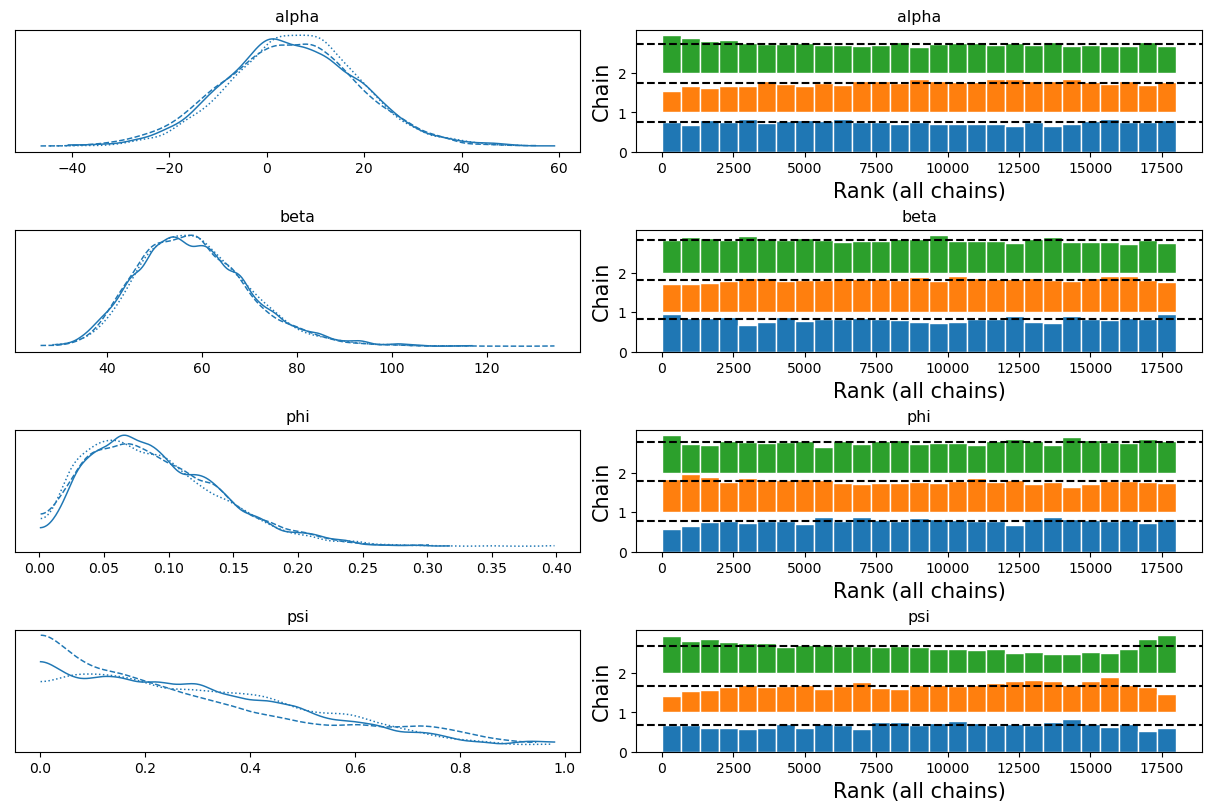

In [64]:
az.plot_trace(trace_lmm, var_names=['alpha','beta', 'phi', 'psi'], kind="rank_bars");

In [65]:
with pm.Model() as m4_subjF:
    a = pm.Normal("alpha", mu=0, sigma=50)
    _b = pm.Normal.dist(mu=0, sigma=100)
    b = pm.Truncated("beta", _b, lower=0, upper=None)
    t = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-(x_data_lmm-500-a)/b)))
    y = pm.Bernoulli("y", p=t, observed=y_data_lmm)
    trace_m4_subj_F = pm.sample(6000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 3 seconds.


<AxesSubplot: >

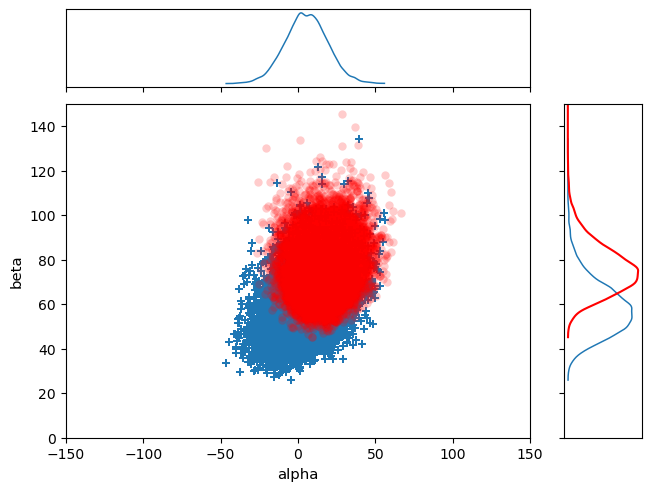

In [66]:
ax = az.plot_pair(trace_lmm_burnin, marginals=True, textsize=10, group='posterior', var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P' });
for i in np.arange(len(ax)):
    ax[i][0].set_xlim([-150, 150])
ax[1][0].set_ylim([0, 150])

az.plot_pair(trace_m4_subj_F, marginals=False, group='posterior', textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', ax=ax[1,0], scatter_kwargs={'marker': 'o', 'facecolors': 'red', 'alpha': 0.2 });

az.plot_dist(trace_m4_subj_F.posterior.beta.T, color='red', rotated=True, ax=ax[1,1])

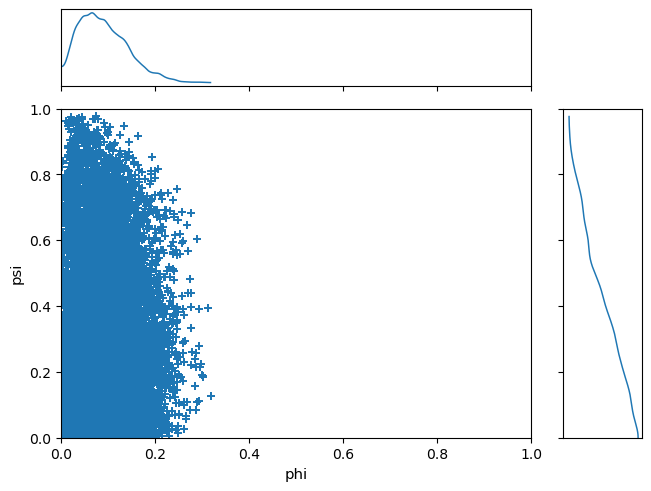

In [67]:
ax = az.plot_pair(trace_lmm_burnin, marginals=True, textsize=10, group='posterior', var_names=['phi', 'psi'], 
                kind='scatter', scatter_kwargs={'marker': 'P' });
for i in np.arange(len(ax)):
    ax[i][0].set_xlim([0, 1])
ax[1][0].set_ylim([0, 1]);

array([830, 830])

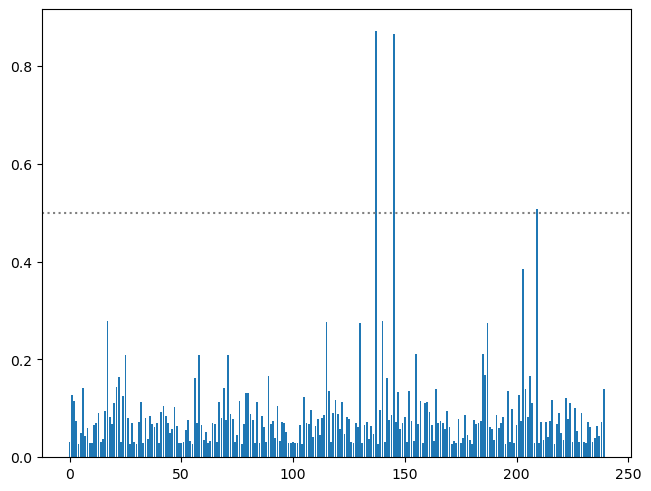

In [68]:
decision_prob_pertrial = np.sum(trace_lmm.posterior.z_t.to_numpy().reshape(18000,240), axis=0)/18000
ax=plt.bar(np.arange(240), decision_prob_pertrial)
plt.axhline(y=0.5, color='gray', linestyle=':');
x_data_lmm[np.where(decision_prob_pertrial>0.55)]

In [69]:
trace_lmm.posterior.dims

Frozen({'chain': 3, 'draw': 6000, 'theta_c_dim_0': 240, 'z_t_dim_0': 240, 'theta_l_dim_0': 240, 'theta_dim_0': 240})

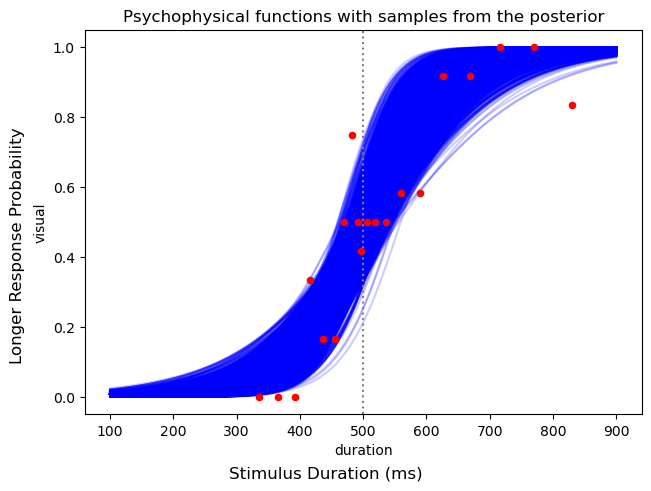

In [70]:
fig, ax = plt.subplots()
post_a = trace_lmm.posterior["alpha"].to_numpy().flatten()
post_b = trace_lmm.posterior["beta"].to_numpy().flatten()

for sample in np.arange(trace_lmm.posterior.dims["draw"]):
    ax.plot(predictor_m1, [logistic_f(xi, 500, post_a[sample], post_b[sample]) for xi in predictor_m1], alpha=0.2, color='b')

fig.supxlabel('Stimulus Duration (ms)')
fig.supylabel('Longer Response Probability')
plt.title('Psychophysical functions with samples from the posterior');
ax.axvline(x=500, color='gray', linestyle=':')

data_subj_A = get_subj_data(subj_F, df, 0)
data_subj_A.plot.scatter(x='duration', y='visual', ax=ax, c='r', zorder=100000);

#### Logistic or Cauchy

We can also compare different likelihood functions by adding a Cauchy function to the model. In the following it is assumed that each subject's behavioral data is generated by either the logistic or the Cauchy model. The same subject is assumed to use the same model for all trials.


Model modification. Now we have both logistic (superscript l) and (superscript c) likelihood functions:
- both likelihood functions have separate $\alpha$ and $\beta$ parameters
- there is a latent base-rate for the proportion of subjects using the logistic model, $\phi$
- the indicator parameter $z_i$ controls which function the decision $\theta_{it}$ for subject $i$ on trial $t$ is based on

$$
\begin{align*}
\alpha^l_i &\sim \text{Gaussian}(0, 1/50^2)
\\
\beta^l_i &\sim \text{TruncatedGaussian}_{+}(0, 1/100^2)
\\
\theta^l_{it} &= 1/{(1+\exp{(-\frac{x_t-s-\alpha^l_i}{\beta^l_i})})} 
\\
\alpha^c_i &\sim \text{Gaussian}(0, 1/50^2)
\\
\beta^c_i &\sim \text{TruncatedGaussian}_{+}(0, 1/100^2)
\\
\theta^c_{it} &= \text{arctan}(\frac{x_t-s-\alpha^c_i}{\beta^c_i}) / \pi + 0.5
\\
\phi &\sim \text{Uniform}(0, 1)
\\
z_i &\sim \text{Bernoulli}(\phi)
\\
\theta_{it} &=
\left\{ 
  \begin{array}{ c l }
    \theta^l_{it} & \textrm{if } z_i = 1 \\
    \theta^c_{it} & \textrm{if } z_i = 0 \\
  \end{array}
\right.
\\
y_{it} &\sim \text{Bernoulli}(\theta_{it})
\end{align*}
$$

In [71]:
subj_list = np.array([7, 9, 15, 18, 6, 3])-1
d = df.loc[df['subj_id'].isin(subj_list)]
d = d.loc[d['modality'] == 'visual']
d.loc[np.isnan(d['Decision']), 'Decision'] = 1 # set missing values to 1 (?!)
for idx, val in enumerate(subj_list):
    d.loc[d['subj_id'] ==  val, 'new_id'] = idx
d['new_id'] = d.new_id.astype(int)
d['Decision'] = d.Decision.astype(int)
d['Stimulus'] = d.Stimulus.astype(np.int64)
d

,subj_id,modality,Stimulus,Decision,Accuracy,new_id
480,2,visual,668,1,1.0,5
481,2,visual,506,0,0.0,5
482,2,visual,491,0,1.0,5
483,2,visual,392,0,1.0,5
484,2,visual,770,1,1.0,5
...,...,...,...,...,...,...
8875,17,visual,482,1,0.0,3
8876,17,visual,365,0,1.0,3
8877,17,visual,437,1,0.0,3
8878,17,visual,335,0,1.0,3


In [72]:
with pm.Model() as lmm_lc:
    # priors
    alpha_l_i = pm.Normal("alpha_l_i", mu=0, sigma=50, shape=6)
    alpha_c_i = pm.Normal("alpha_c_i", mu=0, sigma=50, shape=6)
    _b = pm.Normal.dist(mu=0, sigma=100)
    beta_l_i = pm.Truncated("beta_l_i", _b, lower=0, upper=None, shape=6)
    beta_c_i = pm.Truncated("beta_c_i", _b, lower=0, upper=None, shape=6)
    # likelihoods
    t_l_i_t = pm.Deterministic("theta_lit", pm.invlogit((d.Stimulus.values - 500 - alpha_l_i[d.new_id.values]) / beta_l_i[d.new_id.values]))
    t_c_i_t = pm.Deterministic("theta_cit", at.arctan((d.Stimulus.values - 500 - alpha_c_i[d.new_id.values]) / beta_c_i[d.new_id.values]) / np.pi + 0.5)
    # control parameter
    phi = pm.Uniform("phi", 0, 1)
    z_i = pm.Bernoulli("z_i", p=phi, shape=6)

    # strategy at trial t for subject i 
    t_ = at.switch(at.eq(z_i[d.new_id.values], 0), t_c_i_t, t_l_i_t)
    # 0 and 1 are not allowed in pm.Bernoulli
    t = pm.Deterministic("theta_it", at.switch(at.le(t_, 0), 0.000001, at.switch(at.ge(t_, 1), 0.999999, t_)))
    y = pm.Bernoulli("y", p=t, observed=d.Decision)

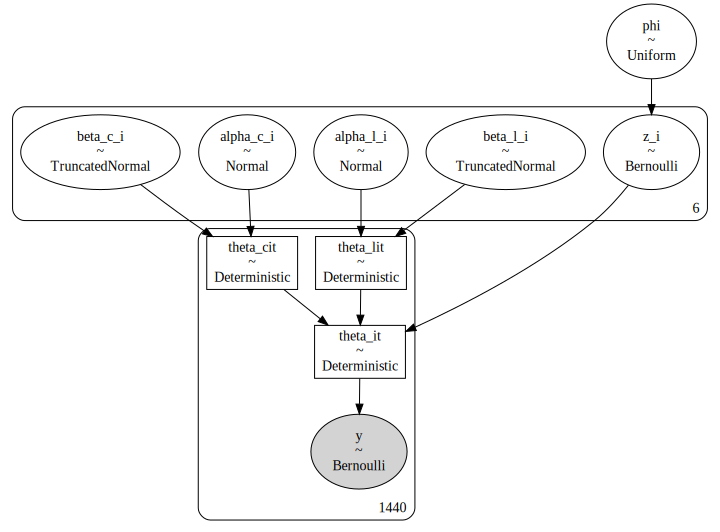

In [73]:
pm.model_to_graphviz(lmm_lc)

In [74]:
with lmm_lc:
    trace_lmm_lc = pm.sample(6000, chains=3, target_accept=0.95)

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [alpha_l_i, alpha_c_i, beta_l_i, beta_c_i, phi]
>BinaryGibbsMetropolis: [z_i]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 74 seconds.


In [75]:
trace_lmm_lc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

/var/folders/_x/c00gpvvj08144m_76ng172dh0000gn/T/ipykernel_76330/39032435.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','A','B','C','D','E','F'])


array([0.733     , 0.69283333, 0.84505556, 0.96816667, 0.86816667,
       0.79877778])

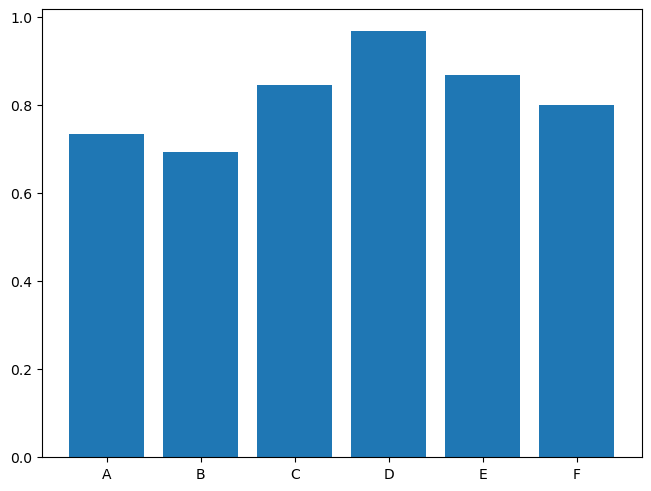

In [76]:
fig, ax = plt.subplots()
ax.set_xticklabels(['','A','B','C','D','E','F'])
logistic_use_prob = np.sum(trace_lmm_lc.posterior.z_i.to_numpy().reshape(18000,6), axis=0)/18000
plt.bar(np.arange(6), logistic_use_prob)

logistic_use_prob

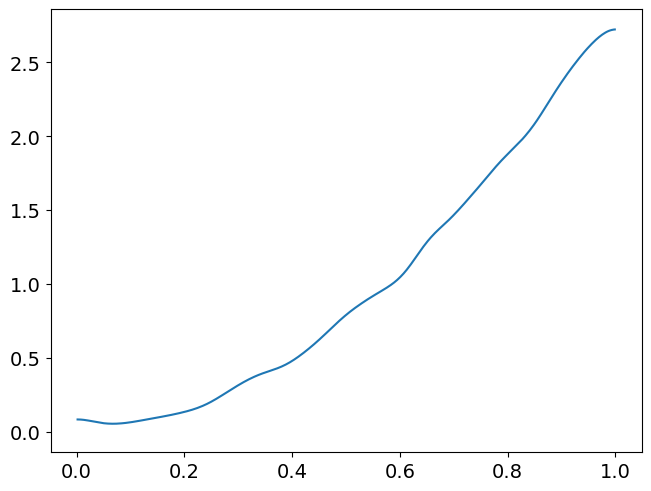

In [77]:
az.plot_dist(trace_lmm_lc.posterior.phi);

Notes on this model:
- if `target_accept` is not increased there are too many divergences, is this about centering? what can we do?
- there are some missing values for some subjects. setting them to 0 resulted in a low probability of logistic function use for subj 4. this is probably because it has the most number of nans. but setting nans to 1 returns results more similar to those in the paper.
- even if we do so, probabilities for using logistic function for subjects do not exactly replicate
- inferences made for $z_i$ can be interpreted as a type of model selection (whether logistic or Cauchy model better for each subject)

### Hierarchical Modeling

Hierarchical: "some key psychological variables in a model are themselves modeled as the outcomes of other cognitive processes"
- individual differences
- two extremes: all subjects are identical - all subjects are completely different
- hierarchy can be used as follows: a specific subject's parameters are sampled from a higher-level distribution of the group
- for $\alpha_i$ and $\beta_i$ of the subject $i$, we can say that there are two other distributions at the group level $\text{Gaussian}(\mu_{\alpha}, 1/\sigma_{\alpha}^2)$ and $\text{TruncatedGaussian}_{+}(\mu_{\beta}, 1/\sigma_{\beta}^2)$ which are parameterized by group-level means and standard deviations

In [78]:
with pm.Model() as mh:
    # group-level distributions
    # shift
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=50)
    sigma_alpha = pm.Uniform("sigma_alpha", 0, 50)
    # scale
    _mu_beta = pm.Normal.dist(mu=0, sigma=100)
    mu_beta = pm.Truncated("mu_beta", _mu_beta, lower=0, upper=None)
    sigma_beta = pm.Uniform("sigma_beta", 0, 100)

    # individual-level
    # shift
    alpha_i = pm.Normal("alpha_i", mu=mu_alpha, sigma=sigma_alpha, shape=6)
    # scale
    _b = pm.Normal.dist(mu=mu_beta, sigma=sigma_beta)
    beta_i = pm.Truncated("beta_i", _b, lower=0, upper=None, shape=6)

    # likelihoods
    theta_it = pm.Deterministic("theta_it", pm.invlogit((d.Stimulus.values - 500 - alpha_i[d.new_id.values]) / beta_i[d.new_id.values]))
   
    y = pm.Bernoulli("y", p=theta_it, observed=d.Decision)

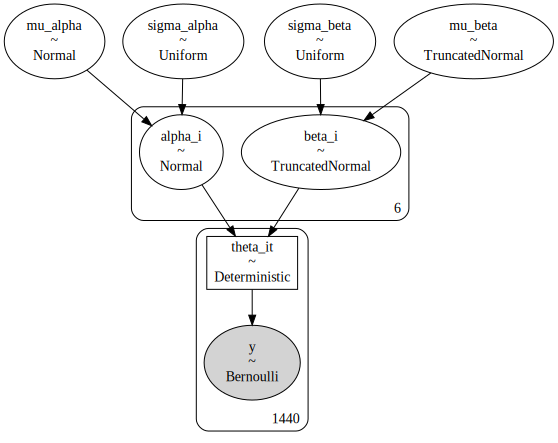

In [79]:
pm.model_to_graphviz(mh)

In [80]:
with mh:
    trace_mh = pm.sample(6000, chains=3, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, alpha_i, beta_i]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 45 seconds.


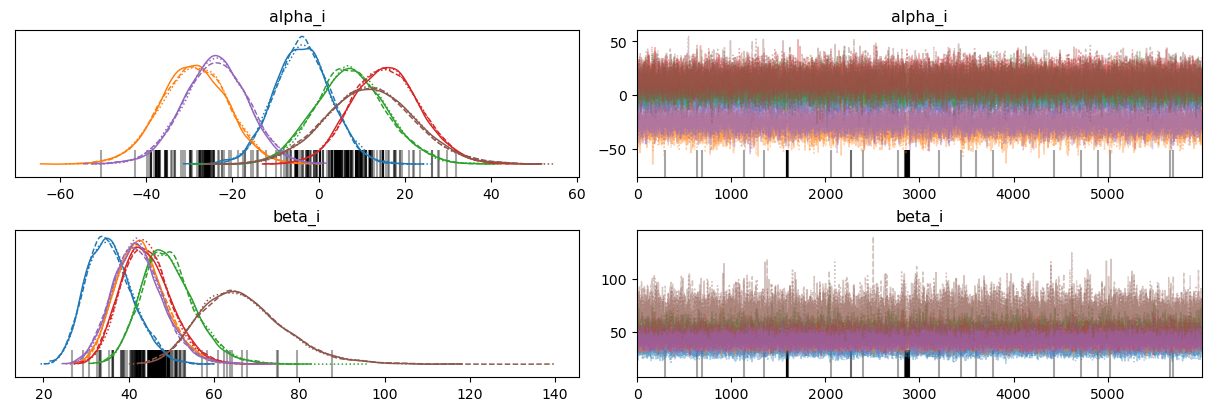

In [81]:
az.plot_trace(trace_mh, var_names=["alpha_i", "beta_i"], compact=True);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


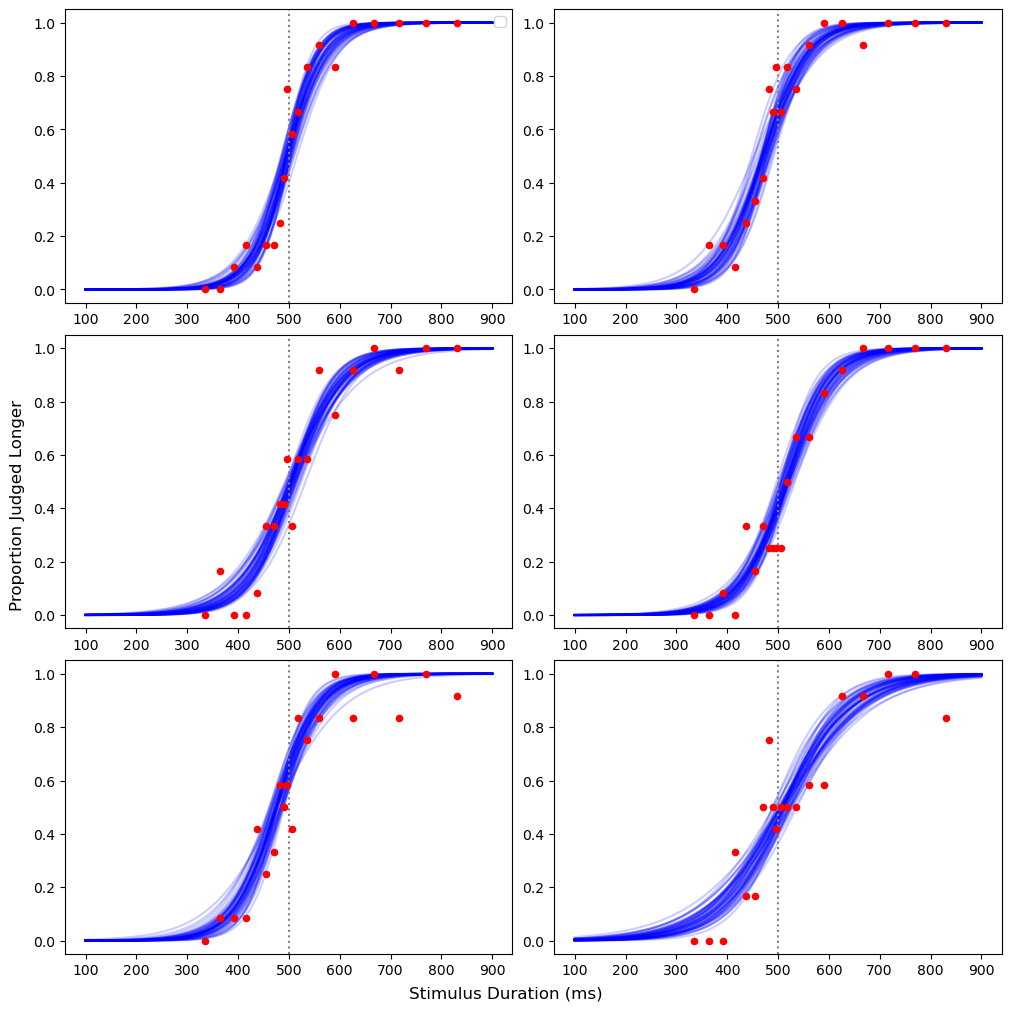

In [82]:
post_a = trace_mh.posterior["alpha_i"].to_numpy().reshape(18000, 6)[1000:18000:300,:]
post_b = trace_mh.posterior["beta_i"].to_numpy().reshape(18000, 6)[1000:18000:300,:]
subjectList = np.array([7, 9, 15, 18, 6, 3]) # indices from matlab code on osf.id (subj A-F)
fig, ax = plt.subplots(3, 2, figsize=(10,10))
for idx, subj in enumerate(subjectList-1): # -1 to match matlab indexing
    subj_ax = ax.flatten()[idx]
    ds = get_subj_data(subj, df, 0)
    ds.plot.scatter(x='duration', y='visual', ax=subj_ax, c='r', zorder=100000);
    for sample in np.arange(post_a.shape[0]):
        curr_ax = ax.flatten()[idx]
        curr_ax.plot(predictor_m1, [logistic_f(xi, 500, post_a[sample][idx], post_b[sample][idx]) for xi in predictor_m1], alpha=0.2, color='b')
    subj_ax.axvline(x=500, color='gray', linestyle=':')
    subj_ax.set_xlabel("")
    subj_ax.set_ylabel("")

fig.supxlabel('Stimulus Duration (ms)')
fig.supylabel('Proportion Judged Longer')
ax.flatten()[0].legend();

In [83]:
with mh:
    pm.sample_posterior_predictive(trace_mh, var_names=["alpha_i", "beta_i"], extend_inferencedata=True)

Sampling: [alpha_i, beta_i]


In [84]:
trace_mh

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

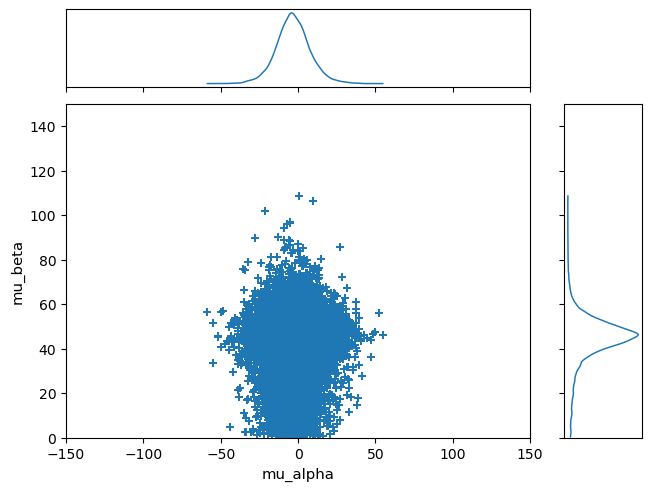

In [85]:
ax = az.plot_pair(trace_mh, marginals=True, textsize=10, group='posterior', var_names=['mu_alpha', 'mu_beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P' });
# for i in np.arange(len(ax)):
#     ax[i][0].set_xlim([0, 1])
ax[1][0].set_ylim([0, 150]);
ax[1][0].set_xlim([-150, 150]);

In [86]:
hm_summary = az.summary(trace_mh, var_names=["alpha_i", "beta_i"])
hm_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_i[0],-3.665,6.554,-16.382,8.087,0.047,0.047,19490.0,11214.0,1.0
alpha_i[1],-28.922,7.816,-43.142,-13.952,0.054,0.040,21206.0,12827.0,1.0
alpha_i[2],7.570,8.301,-8.424,22.929,0.054,0.051,23908.0,13212.0,1.0
alpha_i[3],15.681,7.991,0.883,30.733,0.056,0.044,20471.0,12449.0,1.0
alpha_i[4],-23.951,7.481,-37.384,-9.288,0.052,0.040,20511.0,12347.0,1.0
alpha_i[5],12.017,10.267,-7.260,31.279,0.071,0.063,20842.0,12744.0,1.0
beta_i[0],35.637,5.491,25.879,46.194,0.053,0.038,11462.0,5611.0,1.0
beta_i[1],42.910,5.832,32.067,53.635,0.042,0.030,20227.0,13252.0,1.0
beta_i[2],49.342,6.411,37.846,61.554,0.047,0.034,19102.0,12989.0,1.0
beta_i[3],44.082,5.813,33.571,55.056,0.039,0.028,22725.0,12994.0,1.0


In [87]:
ab_new_subj = trace_mh.posterior_predictive.mean(("alpha_i_dim_2", "beta_i_dim_2"))
new_subj = az.summary(ab_new_subj)
new_subj

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_i,-3.318,15.534,-32.247,27.626,0.123,0.100,16832.0,13556.0,1.0
beta_i,48.029,12.546,25.449,72.061,0.104,0.078,16029.0,10797.0,1.0


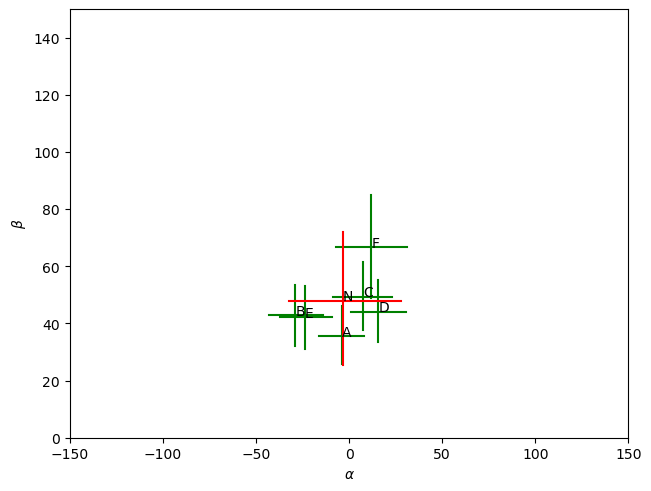

In [88]:
fig, ax = plt.subplots()
a_mean = hm_summary["mean"].values[0:6]
b_mean = hm_summary["mean"].values[6:]
hm3a = hm_summary["hdi_3%"].values[0:6]
hm3b = hm_summary["hdi_3%"].values[6:]
hm97a = hm_summary["hdi_97%"].values[0:6]
hm97b = hm_summary["hdi_97%"].values[6:]
line_lst = []
for n in range(6):
    line_lst.append((a_mean[n], a_mean[n]))
    line_lst.append((hm3b[n], hm97b[n]))
    line_lst.append('g')
    line_lst.append((hm3a[n], hm97a[n]))
    line_lst.append((b_mean[n], b_mean[n]))
    line_lst.append('g')
plt.plot(*line_lst);
plt.xlim([-150, 150])
plt.ylim([0, 150])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$');

lbls = ['A', 'B', 'C', 'D', 'E', 'F']
for i, txt in enumerate(lbls):
    ax.annotate(txt, (a_mean[i], b_mean[i]))

ax.plot((new_subj["mean"][0],new_subj["mean"][0]),(new_subj["hdi_3%"][1],new_subj["hdi_97%"][1]), 'r',
        (new_subj["hdi_3%"][0],new_subj["hdi_97%"][0]),(new_subj["mean"][1],new_subj["mean"][1]),'r')
ax.annotate('N', (new_subj["mean"]));

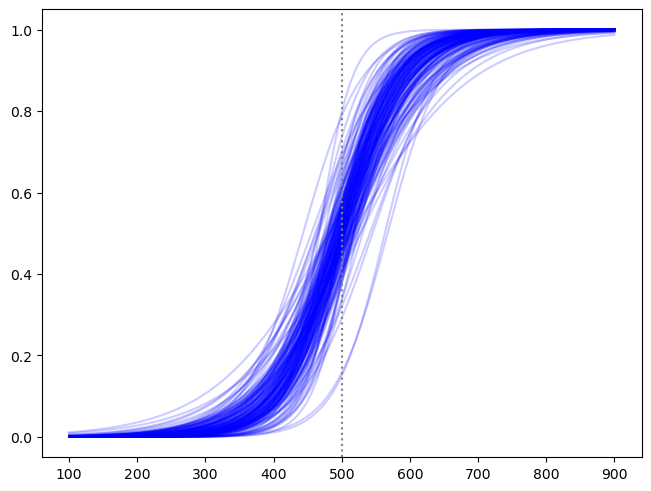

In [89]:
fig, ax = plt.subplots()
post_a = ab_new_subj.alpha_i.to_numpy().flatten()[1000:18000:100]
post_b = ab_new_subj.beta_i.to_numpy().flatten()[1000:18000:100]
for sample in np.arange(post_a.shape[0]):
    ax.plot(predictor_m1, [logistic_f(xi, 500, post_a[sample], post_b[sample]) for xi in predictor_m1], alpha=0.2, color='b')
ax.axvline(x=500, color='gray', linestyle=':');

In [90]:
def JND(a,b):
    return b * (np.log((1-0.5)/0.5) - np.log((1-0.84)/0.84))

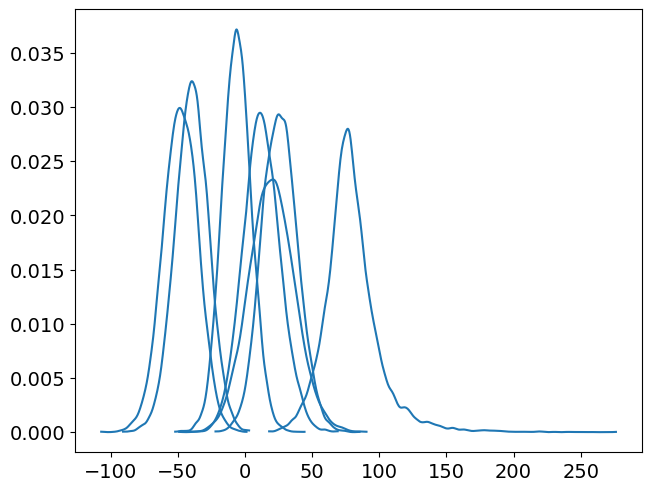

In [91]:
jnd_vals = np.ones((7, 18_000))
subj_alphas = trace_mh.posterior.alpha_i.to_numpy().reshape(18_000, 6)
subj_betas = trace_mh.posterior.beta_i.to_numpy().reshape(18_000, 6)
new_subj_alphas = ab_new_subj.alpha_i.to_numpy().flatten()
new_subj_betas = ab_new_subj.beta_i.to_numpy().flatten()
for subj_num in range(7):
    if subj_num < 6:
        post_a = subj_alphas[:, subj_num]
        post_b = subj_alphas[:, subj_num]
    else:
        post_a = new_subj_alphas
        post_b = new_subj_betas
    for sample in np.arange(post_a.shape[0]):
        jnd_vals[subj_num, sample] = JND(post_a[sample], post_b[sample])
    az.plot_dist(jnd_vals[subj_num, :])

Notes on hierarchical model:
- there were divergences
- plots are not exactly the same
- population means look different
- subject parameters look different for some of them
- JND values seem to be only positive in the chapter, but here there are negative values, and looks different

Notes on individual differences:
- hierarchical modeling assumes subject-level parameters come from group-level distributions; this is consistent with random-effects models (?)
- this type of modeling enables subject-level data pooling: "sharing statistical strength" / "shrinkage"; this is useful when many subjects each contribute relatively few data
- there's more to sampling from Gaussians, "you can also assume that subject-level parameters come from hierarchical latent-mixture distributions: the latent-mixture component captures large qualitative individual differences, and the hierarchical component continues to capture more minor variation within these subgroups"
>All of these approaches to modeling individual differences are largely statistical and lack guiding psychological theory. The goal should be to model the relationships between groups and individuals in the same way the relationships between individuals and their behavior are currently modeled, through the development of theory that creates psychologically meaningful variables and processes.
- an example: cognitive latent variable modeling: cognitive models are coupled with standard psychometric factor theories using a hierarchical Bayesian framework

### Finding Invariances

- there is both an auditory and a visual task
- are there differences between modalities in terms of duration judgements?
- is there a shared model accounting for both modalities (invariant)?
- check if the same psychophysical function at the same parameterization can account for both modalities for a subject

To do this we need to have at least one "different" model. In the following there are two parameters for creating a difference in the shift and scale of the logistic function, $\delta_{\alpha}$ and $\delta_{\beta}$. We'll assume $\alpha^{a} = \alpha + \frac{1}{2} \delta_{\alpha}$ and $\alpha^{v} = \alpha - \frac{1}{2} \delta_{\alpha}$ for the shift parameters, and $\beta^{a} = \beta + \frac{1}{2} \delta_{\beta}$ and $\beta^{v} = \beta - \frac{1}{2} \delta_{\beta}$ for the scale parameters. We'll be able to get the joint posterior distribution of $\delta_{\alpha}$ and $\delta_{\beta}$, and since when $(\delta_{\alpha}, \delta_{\beta})=0$ the "different" model will reduce to "same", Savage-Dickey method can be used to estimate the Bayes factor.

The model:
$$
\begin{align*}
\alpha &\sim \text{Gaussian}(0, 1/50^2)
\\
\beta &\sim \text{TruncatedGaussian}_{+}(0, 1/100^2)
\\
\delta_{\alpha} &\sim \text{Gaussian}(0, 1/20^2)
\\
\delta_{\beta} &\sim \text{Gaussian}(0, 1/40^2)
\\
\alpha^a &= \alpha + \frac{1}{2} \delta_{\alpha}
\\
\alpha^v &= \alpha - \frac{1}{2} \delta_{\alpha}
\\
\beta^a &= \beta + \frac{1}{2} \delta_{\beta}
\\
\beta^v &= \beta - \frac{1}{2} \delta_{\beta}
\\
\theta^a_t &= 1/{(1+\exp{(-\frac{x^a_t-s-\alpha^a}{\beta^a})})}
\\
\theta^v_t &= 1/{(1+\exp{(-\frac{x^v_t-s-\alpha^v}{\beta^v})})} 
\\
y^a_t &\sim \text{Bernoulli}(\theta^a_t)
\\
y^v_t &\sim \text{Bernoulli}(\theta^v_t)
\end{align*}
$$

In [92]:
# get data for subject A (id=6)
subj_A = 6
selected_subj_data = df[df['subj_id']==subj_A].dropna()

In [93]:
subj_B = 8
subj_B_data = df[df['subj_id']==subj_B].dropna()

In [94]:
with pm.Model() as m_inv:
    
    # modality invariant parameters
    alpha = pm.Normal("alpha", mu=0, sigma=50)
    _beta = pm.Normal.dist(mu=0, sigma=100)
    beta = pm.Truncated("beta", _beta, lower=0, upper=None)
    
    # difference makers
    delta_alpha = pm.Normal("delta_alpha", mu=0, sigma=20)
    delta_beta = pm.Normal("delta_beta", mu=0, sigma=40)

    # modality-specifics
    alpha_a = pm.Deterministic("alpha_a", alpha + 0.5 * delta_alpha)
    alpha_v = pm.Deterministic("alpha_v", alpha - 0.5 * delta_alpha)
    beta_a = pm.Deterministic("beta_a", beta + 0.5 * delta_beta)
    beta_v = pm.Deterministic("beta_v", beta - 0.5 * delta_beta)

    # likelihoods
    theta_at = pm.Deterministic("theta_at", pm.invlogit((selected_subj_data[selected_subj_data.modality == 'auditory'].Stimulus.values.astype(np.int64)
                                                             - 500 - alpha_a) / beta_a))
    theta_vt = pm.Deterministic("theta_vt", pm.invlogit((selected_subj_data[selected_subj_data.modality == 'visual'].Stimulus.values.astype(np.int64)
                                                             - 500 - alpha_v) / beta_v))
    
    # t_a = pm.Deterministic("t_a", at.switch(at.le(theta_at, 0), 0.000001, at.switch(at.ge(theta_at, 1), 0.999999, theta_at)))
    # t_v = pm.Deterministic("t_v", at.switch(at.le(theta_vt, 0), 0.000001, at.switch(at.ge(theta_vt, 1), 0.999999, theta_vt)))

    # outcomes
    # y_at = pm.Bernoulli("y_at", p=t_a, observed=selected_subj_data[selected_subj_data.modality == 'auditory'].Decision.values)
    # y_vt = pm.Bernoulli("y_vt", p=t_v, observed=selected_subj_data[selected_subj_data.modality == 'visual'].Decision.values)

    y_at = pm.Bernoulli("y_at", p=theta_at, observed=selected_subj_data[selected_subj_data.modality == 'auditory'].Decision.values)
    y_vt = pm.Bernoulli("y_vt", p=theta_vt, observed=selected_subj_data[selected_subj_data.modality == 'visual'].Decision.values)

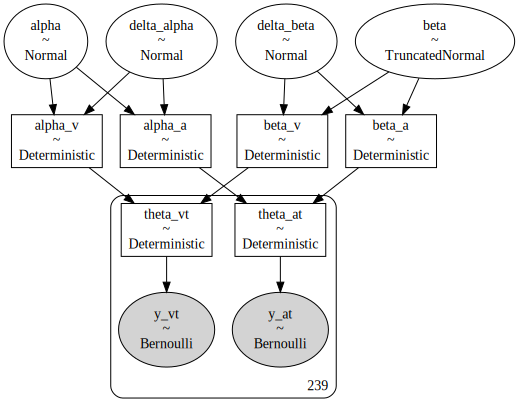

In [95]:
pm.model_to_graphviz(m_inv)

In [96]:
with m_inv:
    trace_m_inv = pm.sample(6000, chains=3, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta, delta_alpha, delta_beta]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 7 seconds.


In [97]:
with m_inv:
    pp_m_inv = pm.sample_prior_predictive(1000)

Sampling: [alpha, beta, delta_alpha, delta_beta, y_at, y_vt]


In [98]:
with pm.Model() as m_inv_sB:
    
    # modality invariant parameters
    alpha = pm.Normal("alpha", mu=0, sigma=50)
    _beta = pm.Normal.dist(mu=0, sigma=100)
    beta = pm.Truncated("beta", _beta, lower=0, upper=None)
    
    # difference makers
    delta_alpha = pm.Normal("delta_alpha", mu=0, sigma=20)
    delta_beta = pm.Normal("delta_beta", mu=0, sigma=40)

    # modality-specifics
    alpha_a = pm.Deterministic("alpha_a", alpha + 0.5 * delta_alpha)
    alpha_v = pm.Deterministic("alpha_v", alpha - 0.5 * delta_alpha)
    beta_a = pm.Deterministic("beta_a", beta + 0.5 * delta_beta)
    beta_v = pm.Deterministic("beta_v", beta - 0.5 * delta_beta)

    # likelihoods
    theta_at = pm.Deterministic("theta_at", pm.invlogit((subj_B_data[subj_B_data.modality == 'auditory'].Stimulus.values.astype(np.int64)
                                                             - 500 - alpha_a) / beta_a))
    theta_vt = pm.Deterministic("theta_vt", pm.invlogit((subj_B_data[subj_B_data.modality == 'visual'].Stimulus.values.astype(np.int64)
                                                             - 500 - alpha_v) / beta_v))
    
    # outcomes
    y_at = pm.Bernoulli("y_at", p=theta_at, observed=subj_B_data[subj_B_data.modality == 'auditory'].Decision.values)
    y_vt = pm.Bernoulli("y_vt", p=theta_vt, observed=subj_B_data[subj_B_data.modality == 'visual'].Decision.values)

    # inference
    trace_m_inv_sB = pm.sample(6000, chains=3, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta, delta_alpha, delta_beta]


Sampling 3 chains for 1_000 tune and 6_000 draw iterations (3_000 + 18_000 draws total) took 8 seconds.


In [99]:
with m_inv_sB:
    pp_m_inv_sB = pm.sample_prior_predictive(1000)

Sampling: [alpha, beta, delta_alpha, delta_beta, y_at, y_vt]


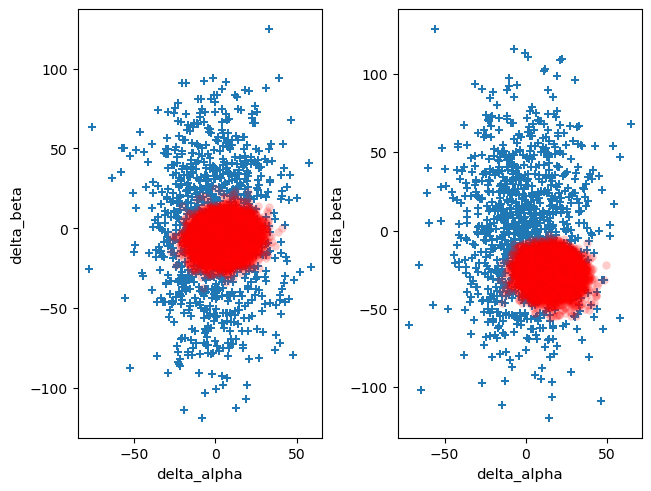

In [100]:
fig, ax = plt.subplots(1, 2)

az.plot_pair(pp_m_inv, marginals=False, textsize=10, group='prior', var_names=['delta_alpha', 'delta_beta'], 
                    kind='scatter', scatter_kwargs={'marker': 'P' }, ax=ax[0]);

az.plot_pair(trace_m_inv, marginals=False, group='posterior', textsize=10, var_names=['delta_alpha', 'delta_beta'], 
                kind='scatter', scatter_kwargs={'marker': 'o', 'facecolors': 'red', 'alpha': 0.2 }, ax=ax[0]);

az.plot_pair(pp_m_inv_sB, marginals=False, textsize=10, group='prior', var_names=['delta_alpha', 'delta_beta'], 
                    kind='scatter', scatter_kwargs={'marker': 'P' }, ax=ax[1]);

az.plot_pair(trace_m_inv_sB, marginals=False, group='posterior', textsize=10, var_names=['delta_alpha', 'delta_beta'], 
                kind='scatter', scatter_kwargs={'marker': 'o', 'facecolors': 'red', 'alpha': 0.2 }, ax=ax[1]);                

### Common-Cause Modeling

* Generally followed by an evidence for invariance
* Same psychological processes (variables) are assumed to be the basis for multiple tasks
* In the following it is assumed that both auditory and visual tasks are generated by the same psychophysical model

$$
\begin{align*}
\alpha &\sim \text{Gaussian}(0, 1/50^2)
\\
\beta &\sim \text{TruncatedGaussian}_{+}(0, 1/100^2)
\\
\theta^a_t &= 1/{(1+\exp{(-\frac{x^a_t-s-\alpha}{\beta})})}
\\
\theta^v_t &= 1/{(1+\exp{(-\frac{x^v_t-s-\alpha}{\beta})})} 
\\
y^a_t &\sim \text{Bernoulli}(\theta^a_t)
\\
y^v_t &\sim \text{Bernoulli}(\theta^v_t)
\end{align*}
$$

In [101]:
with pm.Model() as m_cc:
    
    # modality invariant parameters
    alpha = pm.Normal("alpha", mu=0, sigma=50)
    _beta = pm.Normal.dist(mu=0, sigma=100)
    beta = pm.Truncated("beta", _beta, lower=0, upper=None)
    
    # likelihoods
    theta_at = pm.Deterministic("theta_at", pm.invlogit((selected_subj_data[selected_subj_data.modality == 'auditory'].Stimulus.values.astype(np.int64)
                                                             - 500 - alpha) / beta))
    theta_vt = pm.Deterministic("theta_vt", pm.invlogit((selected_subj_data[selected_subj_data.modality == 'visual'].Stimulus.values.astype(np.int64)
                                                             - 500 - alpha) / beta))
    
    # t_a = pm.Deterministic("t_a", at.switch(at.le(theta_at, 0), 0.000001, at.switch(at.ge(theta_at, 1), 0.999999, theta_at)))
    # t_v = pm.Deterministic("t_v", at.switch(at.le(theta_vt, 0), 0.000001, at.switch(at.ge(theta_vt, 1), 0.999999, theta_vt)))

    # outcomes
    # y_at = pm.Bernoulli("y_at", p=t_a, observed=selected_subj_data[selected_subj_data.modality == 'auditory'].Decision.values)
    y_at = pm.Bernoulli("y_at", p=theta_at, observed=selected_subj_data[selected_subj_data.modality == 'auditory'].Decision.values)
    # y_vt = pm.Bernoulli("y_vt", p=t_v, observed=selected_subj_data[selected_subj_data.modality == 'visual'].Decision.values)
    y_vt = pm.Bernoulli("y_vt", p=theta_vt, observed=selected_subj_data[selected_subj_data.modality == 'visual'].Decision.values)

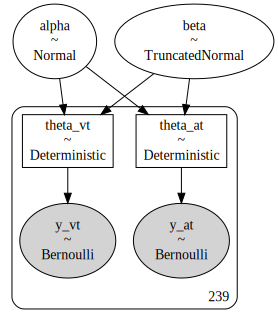

In [102]:
pm.model_to_graphviz(m_cc)

In [103]:
with m_cc:
    trace_m_cc = pm.sample(3000, chains=3, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 2 seconds.


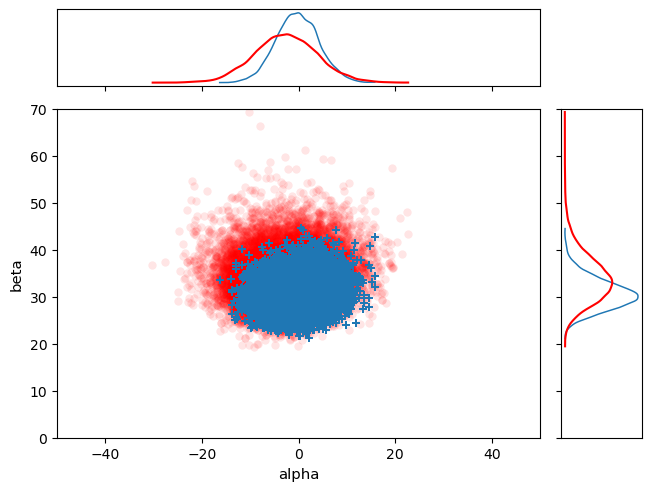

In [104]:
ax = az.plot_pair(trace_m_cc.posterior, marginals=True, textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P'});

for i in np.arange(len(ax)):
    ax[i][0].set_xlim([-50, 50])
ax[1][0].set_ylim([0, 70])

az.plot_pair(post_m4, marginals=False, textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', ax=ax[1,0], scatter_kwargs={'marker': 'o', 'facecolors': 'red', 'alpha': 0.1, 'zorder': 0});

az.plot_dist(post_m4.beta.T, color='red', rotated=True, ax=ax[1,1])
az.plot_dist(post_m4.alpha.T, color='red', rotated=False, ax=ax[0,0]);

In [105]:
trace_m_cc.posterior.alpha

<xarray.DataArray 'alpha' (chain: 3, draw: 3000)>
array([[ 0.13867563, -0.44244775,  1.61177111, ...,  1.05438628,
        -2.54186503,  0.70515892],
       [-0.27250128, -0.27250128, -3.82964167, ..., -1.84915348,
        -1.08084722, -4.78721235],
       [ 6.13167015, -2.61967766, -4.77561308, ...,  0.33299559,
        -7.27313259,  2.31907045]])
Coordinates:
  * chain    (chain) int64 0 1 2
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999

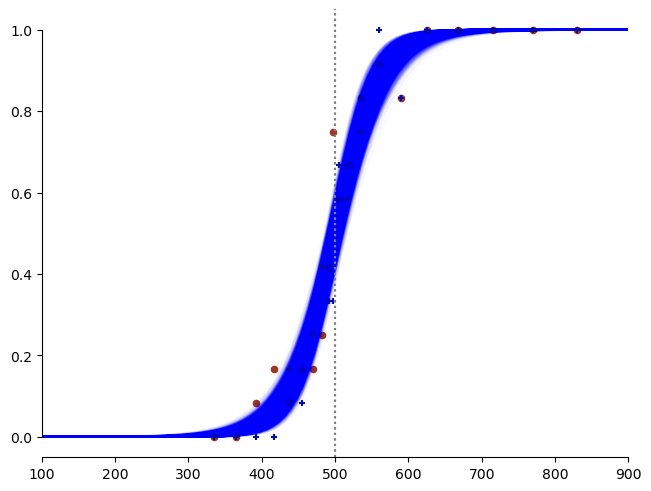

In [106]:
fig, ax = plt.subplots()
get_subj_data(6, df, 1, ax);
post_a = trace_m_cc.posterior.alpha.to_numpy().flatten()
post_b = trace_m_cc.posterior.beta.to_numpy().flatten()
for sample in np.arange(post_a.shape[0]):
    ax.plot(predictor_m1, [logistic_f(xi, 500, post_a[sample], post_b[sample]) for xi in predictor_m1], alpha=0.02, color='b', zorder=0)
ax.axvline(x=500, color='gray', linestyle=':');

### Prediction and Generalization

* predictions: from current task to unobserved data
* generalizations: from one or more different tasks
* e.g. the "new" subject in the hierarchical model (mh above), is a prediction
> "Based on the behavior of observed subjects and the assumptions of a model of their individual differences, it is possible to predict the behavior of a yet-to-be-observed subject."
* in the common cause model above we assumed that the decisions for both tasks were observable. what happens when one (auditory) is partially observable and the other (visual) is not observed at all?
> "Inferences about missing data effectively are probabilistic predictions about unseen data in the auditory task and generalizations to unseen data on the different visual task."

In [107]:
partial_obs = selected_subj_data[selected_subj_data.modality=="auditory"][0:59]

In [131]:
with pm.Model() as m_pred_gen:
    
    # modality invariant parameters
    alpha = pm.Normal("alpha", mu=0, sigma=50)
    _beta = pm.Normal.dist(mu=0, sigma=100)
    beta = pm.Truncated("beta", _beta, lower=0, upper=None)
    
    # likelihoods
    theta_at = pm.Deterministic("theta_at", pm.invlogit((partial_obs[partial_obs.modality == 'auditory'].Stimulus.values.astype(np.int64)
                                                             - 500 - alpha) / beta))
    theta_vt = pm.Deterministic("theta_vt", pm.invlogit((partial_obs[partial_obs.modality == 'visual'].Stimulus.values.astype(np.int64)
                                                             - 500 - alpha) / beta))
    # outcomes
    y_at = pm.Bernoulli("y_at", p=theta_at, observed=partial_obs[partial_obs.modality == 'auditory'].Decision.values)
    y_vt = pm.Bernoulli("y_vt", p=theta_vt, observed=None)

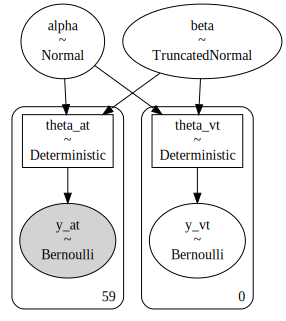

In [132]:
pm.model_to_graphviz(m_pred_gen)

In [133]:
with m_pred_gen:
    trace_m_pg = pm.sample(3000, chains=3, target_accept=0.95)

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, beta]
>BinaryGibbsMetropolis: [y_vt]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 2 seconds.


(0.0, 150.0)

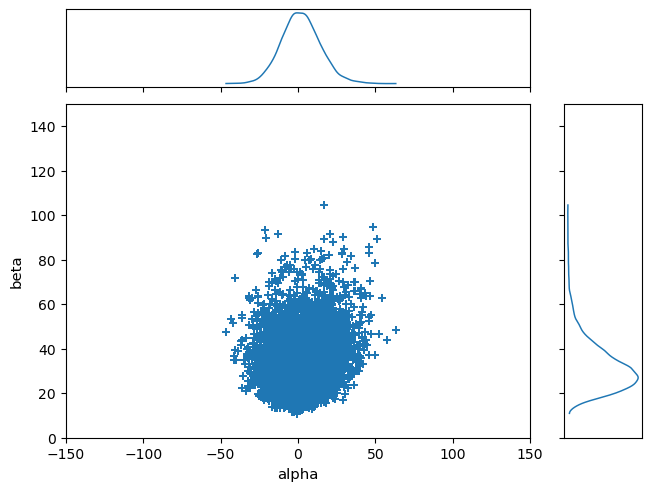

In [134]:
ax = az.plot_pair(trace_m_pg.posterior, marginals=True, textsize=10, var_names=['alpha', 'beta'], 
                kind='scatter', scatter_kwargs={'marker': 'P'});

for i in np.arange(len(ax)):
    ax[i][0].set_xlim([-150, 150])
ax[1][0].set_ylim([0, 150])                

In [115]:
post_a = trace_m_pg.posterior.alpha.to_numpy().flatten()
post_b = trace_m_pg.posterior.beta.to_numpy().flatten()

In [122]:
visual_trials = selected_subj_data[selected_subj_data.modality=="visual"]
auditory_trials = selected_subj_data[selected_subj_data.modality=="auditory"]

In [154]:
pred_acc = np.zeros((2,len(visual_trials)))
for trial in np.arange(len(visual_trials)):
    stim_val_vis = visual_trials.iloc[trial,:].Stimulus
    decision_vis = visual_trials.iloc[trial,:].Decision
    true_pred_vis = 0
    stim_val_au = auditory_trials.iloc[trial,:].Stimulus
    decision_au = auditory_trials.iloc[trial,:].Decision
    true_pred_au = 0
    for iSample in np.arange(len(post_a)):
        theta_vis = logistic_f(stim_val_vis, 500, post_a[iSample], post_b[iSample])
        theta_au = logistic_f(stim_val_au, 500, post_a[iSample], post_b[iSample])
        out_vis = np.random.binomial(n=1, p=theta_vis)
        out_au = np.random.binomial(n=1, p=theta_au)
        if out_vis == decision_vis:
            true_pred_vis += 1
        if out_au == decision_au:
            true_pred_au += 1
    pred_acc[0,trial] = true_pred_vis/len(post_a)
    pred_acc[1,trial] = true_pred_au/len(post_a)

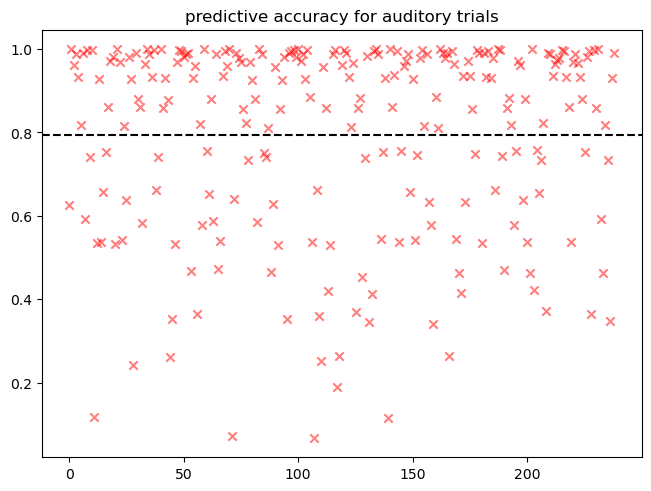

In [162]:
plt.scatter(np.arange(np.shape(pred_acc)[1]), pred_acc[1,:], marker="x", color="r", alpha=0.5);
plt.title("predictive accuracy for auditory trials")
plt.axhline(np.mean(pred_acc[1,:]),linestyle='--',c="k");

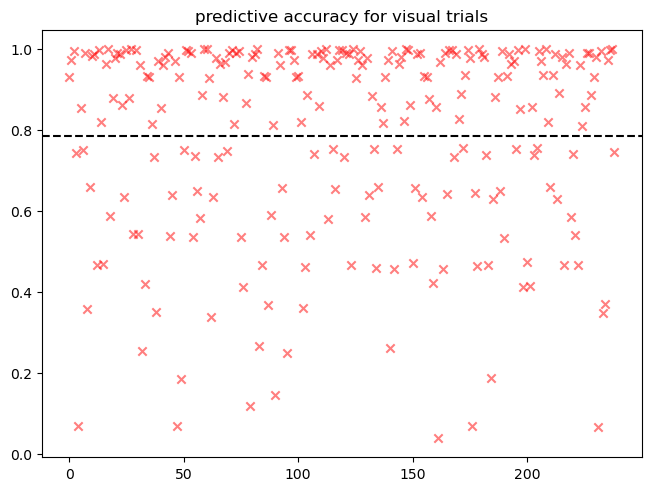

In [163]:
plt.scatter(np.arange(np.shape(pred_acc)[1]), pred_acc[0,:], marker="x", color="r", alpha=0.5);
plt.title("predictive accuracy for visual trials")
plt.axhline(np.mean(pred_acc[0,:]),linestyle='--',c="k");

In [164]:
print("average accuracies: visual = {}, auditory = {}".format(np.mean(pred_acc[0,:]),np.mean(pred_acc[1,:])))

average accuracies: visual = 0.7844170153417015, auditory = 0.7938768014876803
